In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

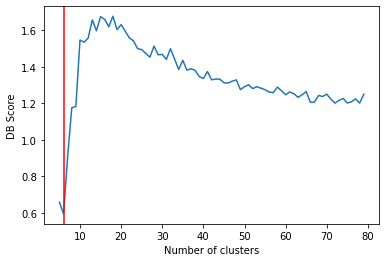

{0, 1, 2, 3, 4, 5}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

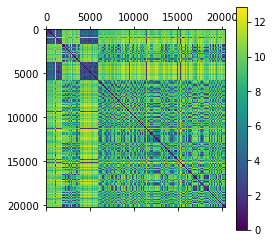

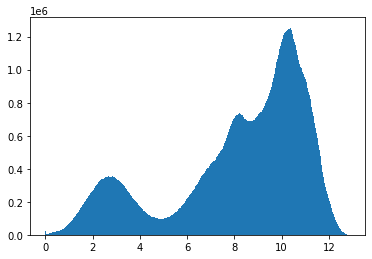

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

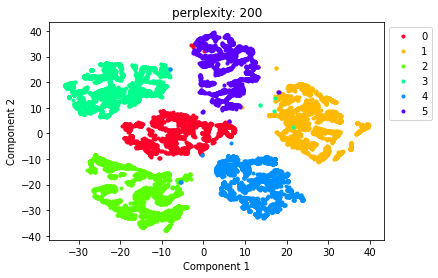

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9913763366678164


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.16530840394679283
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.494475138121547
layer 4: 0.494475138121547
layer 5: 0.46357044198895025
layer 6: 0.3708563535911602
layer 7: 0.2472375690607735
layer 8: 0.14679730662983426
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.786 | Reg loss: 0.016 | Tree loss: 1.786 | Accuracy: 0.195000 | 13.51 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.773 | Reg loss: 0.016 | Tree loss: 1.773 | Accuracy: 0.190500 | 7.636 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.756 | Reg loss: 0.016 | Tree loss: 1.756 | Accuracy: 0.209500 | 5.614 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.743 | Reg loss: 0.015 | Tree loss: 1.743 | Accuracy: 0.346500 | 4.584 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.741 | Reg loss: 0.015 | Tree loss: 1.741 | Accuracy: 0.410000 | 3.959 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.725 | Reg loss: 0.015 | Tree loss: 1.725 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.735 | Reg loss: 0.013 | Tree loss: 1.735 | Accuracy: 0.472500 | 2.662 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.714 | Reg loss: 0.013 | Tree loss: 1.714 | Accuracy: 0.486000 | 2.64 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.695 | Reg loss: 0.013 | Tree loss: 1.695 | Accuracy: 0.474500 | 2.623 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.674 | Reg loss: 0.013 | Tree loss: 1.674 | Accuracy: 0.467000 | 2.605 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.648 | Reg loss: 0.014 | Tree loss: 1.648 | Accuracy: 0.483500 | 2.589 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.626 | Reg loss: 0.014 | Tree loss: 1.626 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 1.628 | Reg loss: 0.016 | Tree loss: 1.628 | Accuracy: 0.600500 | 2.476 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 1.586 | Reg loss: 0.016 | Tree loss: 1.586 | Accuracy: 0.603500 | 2.47 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 1.545 | Reg loss: 0.016 | Tree loss: 1.545 | Accuracy: 0.584000 | 2.463 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.489 | Reg loss: 0.016 | Tree loss: 1.489 | Accuracy: 0.641000 | 2.456 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.451 | Reg loss: 0.016 | Tree loss: 1.451 | Accuracy: 0.642500 | 2.448 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.405 | Reg loss: 0.016 | Tree loss: 1.405 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 1.425 | Reg loss: 0.018 | Tree loss: 1.425 | Accuracy: 0.626000 | 2.41 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 1.371 | Reg loss: 0.018 | Tree loss: 1.371 | Accuracy: 0.620500 | 2.404 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 1.318 | Reg loss: 0.018 | Tree loss: 1.318 | Accuracy: 0.608500 | 2.397 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 1.255 | Reg loss: 0.018 | Tree loss: 1.255 | Accuracy: 0.626500 | 2.391 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 1.215 | Reg loss: 0.019 | Tree loss: 1.215 | Accuracy: 0.635500 | 2.386 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.163 | Reg loss: 0.019 | Tree loss: 1.163 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 1.212 | Reg loss: 0.021 | Tree loss: 1.212 | Accuracy: 0.662000 | 2.414 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 1.183 | Reg loss: 0.021 | Tree loss: 1.183 | Accuracy: 0.666000 | 2.408 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 1.131 | Reg loss: 0.021 | Tree loss: 1.131 | Accuracy: 0.711500 | 2.403 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 1.049 | Reg loss: 0.021 | Tree loss: 1.049 | Accuracy: 0.736000 | 2.399 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 1.010 | Reg loss: 0.021 | Tree loss: 1.010 | Accuracy: 0.750500 | 2.395 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 0.980 | Reg loss: 0.021 | Tree loss: 0.980 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 1.060 | Reg loss: 0.022 | Tree loss: 1.060 | Accuracy: 0.691000 | 2.406 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 1.011 | Reg loss: 0.022 | Tree loss: 1.011 | Accuracy: 0.710500 | 2.403 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 0.993 | Reg loss: 0.022 | Tree loss: 0.993 | Accuracy: 0.711500 | 2.399 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 0.955 | Reg loss: 0.022 | Tree loss: 0.955 | Accuracy: 0.731500 | 2.394 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 0.917 | Reg loss: 0.022 | Tree loss: 0.917 | Accuracy: 0.755000 | 2.389 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 0.853 | Reg loss: 0.023 | Tree loss: 0.853 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 0.972 | Reg loss: 0.023 | Tree loss: 0.972 | Accuracy: 0.694500 | 2.399 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 0.923 | Reg loss: 0.023 | Tree loss: 0.923 | Accuracy: 0.712000 | 2.396 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 0.881 | Reg loss: 0.024 | Tree loss: 0.881 | Accuracy: 0.738500 | 2.393 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 0.828 | Reg loss: 0.024 | Tree loss: 0.828 | Accuracy: 0.775000 | 2.389 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 0.812 | Reg loss: 0.024 | Tree loss: 0.812 | Accuracy: 0.796000 | 2.386 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 0.766 | Reg loss: 0.024 | Tree loss: 0.766 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 0.894 | Reg loss: 0.024 | Tree loss: 0.894 | Accuracy: 0.706500 | 2.339 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 0.854 | Reg loss: 0.024 | Tree loss: 0.854 | Accuracy: 0.707000 | 2.337 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 0.798 | Reg loss: 0.024 | Tree loss: 0.798 | Accuracy: 0.750500 | 2.334 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 0.755 | Reg loss: 0.024 | Tree loss: 0.755 | Accuracy: 0.779500 | 2.332 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 0.749 | Reg loss: 0.024 | Tree loss: 0.749 | Accuracy: 0.804500 | 2.329 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 0.706 | Reg loss: 0.024 | Tree loss: 0.706 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 0.838 | Reg loss: 0.025 | Tree loss: 0.838 | Accuracy: 0.719500 | 2.336 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 0.799 | Reg loss: 0.025 | Tree loss: 0.799 | Accuracy: 0.737000 | 2.332 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 0.751 | Reg loss: 0.025 | Tree loss: 0.751 | Accuracy: 0.764000 | 2.329 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 0.710 | Reg loss: 0.025 | Tree loss: 0.710 | Accuracy: 0.791500 | 2.326 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 0.668 | Reg loss: 0.025 | Tree loss: 0.668 | Accuracy: 0.829000 | 2.323 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 0.638 | Reg loss: 0.025 | Tree loss: 0.638 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 0.791 | Reg loss: 0.025 | Tree loss: 0.791 | Accuracy: 0.743500 | 2.341 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 0.751 | Reg loss: 0.025 | Tree loss: 0.751 | Accuracy: 0.744000 | 2.339 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 0.710 | Reg loss: 0.025 | Tree loss: 0.710 | Accuracy: 0.766000 | 2.337 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 0.655 | Reg loss: 0.025 | Tree loss: 0.655 | Accuracy: 0.803500 | 2.335 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 0.639 | Reg loss: 0.025 | Tree loss: 0.639 | Accuracy: 0.822500 | 2.333 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 0.615 | Reg loss: 0.025 | Tree loss: 0.615 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 0.747 | Reg loss: 0.026 | Tree loss: 0.747 | Accuracy: 0.759500 | 2.33 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 0.728 | Reg loss: 0.026 | Tree loss: 0.728 | Accuracy: 0.762000 | 2.328 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 0.674 | Reg loss: 0.026 | Tree loss: 0.674 | Accuracy: 0.772000 | 2.326 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 0.652 | Reg loss: 0.026 | Tree loss: 0.652 | Accuracy: 0.782000 | 2.324 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 0.629 | Reg loss: 0.026 | Tree loss: 0.629 | Accuracy: 0.798500 | 2.323 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 0.590 | Reg loss: 0.026 | Tree loss: 0.590 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 0.725 | Reg loss: 0.026 | Tree loss: 0.725 | Accuracy: 0.757500 | 2.356 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 0.685 | Reg loss: 0.026 | Tree loss: 0.685 | Accuracy: 0.779000 | 2.354 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 0.660 | Reg loss: 0.026 | Tree loss: 0.660 | Accuracy: 0.780500 | 2.352 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 0.634 | Reg loss: 0.026 | Tree loss: 0.634 | Accuracy: 0.790000 | 2.351 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 0.600 | Reg loss: 0.026 | Tree loss: 0.600 | Accuracy: 0.829500 | 2.349 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 0.567 | Reg loss: 0.026 | Tree loss: 0.567 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 0.696 | Reg loss: 0.026 | Tree loss: 0.696 | Accuracy: 0.768000 | 2.346 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 0.662 | Reg loss: 0.026 | Tree loss: 0.662 | Accuracy: 0.771000 | 2.345 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 0.643 | Reg loss: 0.026 | Tree loss: 0.643 | Accuracy: 0.776500 | 2.344 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 0.601 | Reg loss: 0.026 | Tree loss: 0.601 | Accuracy: 0.807000 | 2.343 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 0.569 | Reg loss: 0.026 | Tree loss: 0.569 | Accuracy: 0.836500 | 2.342 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 0.541 | Reg loss: 0.026 | Tree loss: 0.541 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 0.699 | Reg loss: 0.027 | Tree loss: 0.699 | Accuracy: 0.749500 | 2.325 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 0.655 | Reg loss: 0.027 | Tree loss: 0.655 | Accuracy: 0.770500 | 2.324 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 0.598 | Reg loss: 0.027 | Tree loss: 0.598 | Accuracy: 0.799000 | 2.323 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 0.582 | Reg loss: 0.027 | Tree loss: 0.582 | Accuracy: 0.811000 | 2.321 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.558 | Reg loss: 0.027 | Tree loss: 0.558 | Accuracy: 0.843000 | 2.32 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 0.557 | Reg loss: 0.027 | Tree loss: 0.557 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 0.663 | Reg loss: 0.027 | Tree loss: 0.663 | Accuracy: 0.765500 | 2.321 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 0.653 | Reg loss: 0.027 | Tree loss: 0.653 | Accuracy: 0.762500 | 2.319 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 0.596 | Reg loss: 0.027 | Tree loss: 0.596 | Accuracy: 0.802000 | 2.318 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 0.570 | Reg loss: 0.027 | Tree loss: 0.570 | Accuracy: 0.815500 | 2.316 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 0.544 | Reg loss: 0.027 | Tree loss: 0.544 | Accuracy: 0.833000 | 2.314 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 0.525 | Reg loss: 0.027 | Tree loss: 0.525 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 0.650 | Reg loss: 0.027 | Tree loss: 0.650 | Accuracy: 0.761000 | 2.327 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 0.632 | Reg loss: 0.027 | Tree loss: 0.632 | Accuracy: 0.754500 | 2.326 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 0.609 | Reg loss: 0.027 | Tree loss: 0.609 | Accuracy: 0.767000 | 2.324 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 0.553 | Reg loss: 0.027 | Tree loss: 0.553 | Accuracy: 0.810500 | 2.323 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 0.536 | Reg loss: 0.027 | Tree loss: 0.536 | Accuracy: 0.835500 | 2.322 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 0.506 | Reg loss: 0.027 | Tree loss: 0.506 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 0.630 | Reg loss: 0.027 | Tree loss: 0.630 | Accuracy: 0.765000 | 2.326 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 0.592 | Reg loss: 0.027 | Tree loss: 0.592 | Accuracy: 0.778500 | 2.325 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 0.597 | Reg loss: 0.027 | Tree loss: 0.597 | Accuracy: 0.771500 | 2.324 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 0.532 | Reg loss: 0.027 | Tree loss: 0.532 | Accuracy: 0.837500 | 2.323 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 0.521 | Reg loss: 0.027 | Tree loss: 0.521 | Accuracy: 0.846000 | 2.322 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 0.515 | Reg loss: 0.027 | Tree loss: 0.515 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 0.628 | Reg loss: 0.027 | Tree loss: 0.628 | Accuracy: 0.765000 | 2.307 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 0.603 | Reg loss: 0.027 | Tree loss: 0.603 | Accuracy: 0.768000 | 2.306 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 0.570 | Reg loss: 0.027 | Tree loss: 0.570 | Accuracy: 0.785500 | 2.305 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 0.539 | Reg loss: 0.027 | Tree loss: 0.539 | Accuracy: 0.824500 | 2.304 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 0.523 | Reg loss: 0.028 | Tree loss: 0.523 | Accuracy: 0.843500 | 2.304 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 0.480 | Reg loss: 0.028 | Tree loss: 0.480 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 0.625 | Reg loss: 0.028 | Tree loss: 0.625 | Accuracy: 0.760500 | 2.304 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 0.582 | Reg loss: 0.028 | Tree loss: 0.582 | Accuracy: 0.782000 | 2.303 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 0.560 | Reg loss: 0.028 | Tree loss: 0.560 | Accuracy: 0.784000 | 2.302 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 0.559 | Reg loss: 0.028 | Tree loss: 0.559 | Accuracy: 0.808000 | 2.301 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 0.507 | Reg loss: 0.028 | Tree loss: 0.507 | Accuracy: 0.854000 | 2.3 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 0.495 | Reg loss: 0.028 | Tree loss: 0.495 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 95 | Batch: 000 / 011 | Total loss: 0.612 | Reg loss: 0.028 | Tree loss: 0.612 | Accuracy: 0.768000 | 2.308 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 0.581 | Reg loss: 0.028 | Tree loss: 0.581 | Accuracy: 0.785000 | 2.307 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 0.551 | Reg loss: 0.028 | Tree loss: 0.551 | Accuracy: 0.794000 | 2.306 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 0.527 | Reg loss: 0.028 | Tree loss: 0.527 | Accuracy: 0.822500 | 2.305 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 0.493 | Reg loss: 0.028 | Tree loss: 0.493 | Accuracy: 0.853000 | 2.304 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 0.497 | Reg loss: 0.028 | Tree loss: 0.497 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 100 | Batch: 000 / 011 | Total loss: 0.603 | Reg loss: 0.028 | Tree loss: 0.603 | Accuracy: 0.766000 | 2.315 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 0.561 | Reg loss: 0.028 | Tree loss: 0.561 | Accuracy: 0.790500 | 2.314 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 0.551 | Reg loss: 0.028 | Tree loss: 0.551 | Accuracy: 0.787000 | 2.313 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 0.524 | Reg loss: 0.028 | Tree loss: 0.524 | Accuracy: 0.820500 | 2.312 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 0.495 | Reg loss: 0.028 | Tree loss: 0.495 | Accuracy: 0.843000 | 2.312 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 0.481 | Reg loss: 0.028 | Tree loss: 0.4

Epoch: 104 | Batch: 010 / 011 | Total loss: 0.486 | Reg loss: 0.028 | Tree loss: 0.486 | Accuracy: 0.839590 | 2.317 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 0.562 | Reg loss: 0.028 | Tree loss: 0.562 | Accuracy: 0.796000 | 2.326 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 0.560 | Reg loss: 0.028 | Tree loss: 0.560 | Accuracy: 0.793000 | 2.324 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 0.572 | Reg loss: 0.028 | Tree loss: 0.572 | Accuracy: 0.776500 | 2.323 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 0.514 | Reg loss: 0.028 | Tree loss: 0.514 | Accuracy: 0.826000 | 2.322 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 0.480 | Reg loss: 0.028 | Tree loss: 0.4

Epoch: 109 | Batch: 009 / 011 | Total loss: 0.471 | Reg loss: 0.028 | Tree loss: 0.471 | Accuracy: 0.857500 | 2.319 sec/iter
Epoch: 109 | Batch: 010 / 011 | Total loss: 0.457 | Reg loss: 0.028 | Tree loss: 0.457 | Accuracy: 0.866894 | 2.318 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 110 | Batch: 000 / 011 | Total loss: 0.575 | Reg loss: 0.028 | Tree loss: 0.575 | Accuracy: 0.787500 | 2.327 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 0.555 | Reg loss: 0.028 | Tree loss: 0.555 | Accuracy: 0.794500 | 2.326 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.514 | Reg loss: 0.028 | Tree loss: 0.514 | Accuracy: 0.822500 | 2.325 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.519 | Reg loss: 0.028 | Tree loss: 0.5

Epoch: 114 | Batch: 008 / 011 | Total loss: 0.472 | Reg loss: 0.028 | Tree loss: 0.472 | Accuracy: 0.845500 | 2.321 sec/iter
Epoch: 114 | Batch: 009 / 011 | Total loss: 0.467 | Reg loss: 0.028 | Tree loss: 0.467 | Accuracy: 0.852500 | 2.32 sec/iter
Epoch: 114 | Batch: 010 / 011 | Total loss: 0.431 | Reg loss: 0.028 | Tree loss: 0.431 | Accuracy: 0.860068 | 2.319 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 0.582 | Reg loss: 0.028 | Tree loss: 0.582 | Accuracy: 0.771000 | 2.329 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.574 | Reg loss: 0.028 | Tree loss: 0.574 | Accuracy: 0.770500 | 2.328 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.526 | Reg loss: 0.028 | Tree loss: 0.52

Epoch: 119 | Batch: 007 / 011 | Total loss: 0.462 | Reg loss: 0.028 | Tree loss: 0.462 | Accuracy: 0.856000 | 2.315 sec/iter
Epoch: 119 | Batch: 008 / 011 | Total loss: 0.443 | Reg loss: 0.028 | Tree loss: 0.443 | Accuracy: 0.865500 | 2.315 sec/iter
Epoch: 119 | Batch: 009 / 011 | Total loss: 0.441 | Reg loss: 0.028 | Tree loss: 0.441 | Accuracy: 0.858000 | 2.314 sec/iter
Epoch: 119 | Batch: 010 / 011 | Total loss: 0.467 | Reg loss: 0.028 | Tree loss: 0.467 | Accuracy: 0.843003 | 2.313 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.598 | Reg loss: 0.028 | Tree loss: 0.598 | Accuracy: 0.764000 | 2.322 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.539 | Reg loss: 0.028 | Tree loss: 0.5

Epoch: 124 | Batch: 006 / 011 | Total loss: 0.462 | Reg loss: 0.028 | Tree loss: 0.462 | Accuracy: 0.857000 | 2.301 sec/iter
Epoch: 124 | Batch: 007 / 011 | Total loss: 0.458 | Reg loss: 0.028 | Tree loss: 0.458 | Accuracy: 0.863000 | 2.3 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 0.473 | Reg loss: 0.028 | Tree loss: 0.473 | Accuracy: 0.851000 | 2.3 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 0.447 | Reg loss: 0.028 | Tree loss: 0.447 | Accuracy: 0.859500 | 2.299 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 0.446 | Reg loss: 0.028 | Tree loss: 0.446 | Accuracy: 0.836177 | 2.298 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.576 | Reg loss: 0.028 | Tree loss: 0.576 |

Epoch: 129 | Batch: 005 / 011 | Total loss: 0.450 | Reg loss: 0.028 | Tree loss: 0.450 | Accuracy: 0.866500 | 2.302 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.448 | Reg loss: 0.028 | Tree loss: 0.448 | Accuracy: 0.874500 | 2.302 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.483 | Reg loss: 0.028 | Tree loss: 0.483 | Accuracy: 0.849500 | 2.301 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 0.440 | Reg loss: 0.028 | Tree loss: 0.440 | Accuracy: 0.863500 | 2.3 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.431 | Reg loss: 0.028 | Tree loss: 0.431 | Accuracy: 0.863000 | 2.3 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.469 | Reg loss: 0.028 | Tree loss: 0.469 | Accuracy: 0.839590 | 2.299 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237569

Epoch: 134 | Batch: 004 / 011 | Total loss: 0.474 | Reg loss: 0.028 | Tree loss: 0.474 | Accuracy: 0.855500 | 2.306 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.028 | Tree loss: 0.486 | Accuracy: 0.853000 | 2.305 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.028 | Tree loss: 0.437 | Accuracy: 0.862000 | 2.304 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.448 | Reg loss: 0.028 | Tree loss: 0.448 | Accuracy: 0.868500 | 2.304 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.435 | Reg loss: 0.028 | Tree loss: 0.435 | Accuracy: 0.867500 | 2.303 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.446 | Reg loss: 0.028 | Tree loss: 0.446 | Accuracy: 0.851500 | 2.302 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 0.471 | Reg loss: 0.028 | Tree loss: 0.471 | Accuracy: 0.839590 | 2.301 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 139 | Batch: 003 / 011 | Total loss: 0.495 | Reg loss: 0.028 | Tree loss: 0.495 | Accuracy: 0.821000 | 2.316 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.475 | Reg loss: 0.028 | Tree loss: 0.475 | Accuracy: 0.850000 | 2.315 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.427 | Reg loss: 0.028 | Tree loss: 0.427 | Accuracy: 0.881000 | 2.314 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.441 | Reg loss: 0.028 | Tree loss: 0.441 | Accuracy: 0.865500 | 2.314 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.449 | Reg loss: 0.028 | Tree loss: 0.449 | Accuracy: 0.854000 | 2.313 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.426 | Reg loss: 0.028 | Tree loss: 0.426 | Accuracy: 0.869500 | 2.312 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.445 | Reg loss: 0.028 | Tree loss: 0.445 | Accuracy: 0.862000 | 2.312 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.484 | Reg loss: 0.028 | Tree loss: 0.484 | Accuracy: 0.839590 | 2.311 sec/iter


Epoch: 144 | Batch: 002 / 011 | Total loss: 0.485 | Reg loss: 0.028 | Tree loss: 0.485 | Accuracy: 0.823000 | 2.32 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 0.483 | Reg loss: 0.028 | Tree loss: 0.483 | Accuracy: 0.832500 | 2.319 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 0.483 | Reg loss: 0.028 | Tree loss: 0.483 | Accuracy: 0.829000 | 2.319 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 0.472 | Reg loss: 0.028 | Tree loss: 0.472 | Accuracy: 0.858500 | 2.318 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.474 | Reg loss: 0.028 | Tree loss: 0.474 | Accuracy: 0.852000 | 2.318 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.028 | Tree loss: 0.439 | Accuracy: 0.857000 | 2.317 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.429 | Reg loss: 0.028 | Tree loss: 0.429 | Accuracy: 0.865000 | 2.317 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.434 | Reg loss: 0.028 | Tree loss: 0.434 | Accuracy: 0.858000 | 2.316 sec/iter
E

Epoch: 149 | Batch: 001 / 011 | Total loss: 0.529 | Reg loss: 0.028 | Tree loss: 0.529 | Accuracy: 0.786000 | 2.314 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 0.497 | Reg loss: 0.028 | Tree loss: 0.497 | Accuracy: 0.813000 | 2.313 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 0.495 | Reg loss: 0.028 | Tree loss: 0.495 | Accuracy: 0.825500 | 2.313 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 0.468 | Reg loss: 0.028 | Tree loss: 0.468 | Accuracy: 0.861000 | 2.312 sec/iter
Epoch: 149 | Batch: 005 / 011 | Total loss: 0.443 | Reg loss: 0.028 | Tree loss: 0.443 | Accuracy: 0.872500 | 2.312 sec/iter
Epoch: 149 | Batch: 006 / 011 | Total loss: 0.469 | Reg loss: 0.028 | Tree loss: 0.469 | Accuracy: 0.852000 | 2.311 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 0.448 | Reg loss: 0.028 | Tree loss: 0.448 | Accuracy: 0.864000 | 2.311 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 0.439 | Reg loss: 0.028 | Tree loss: 0.439 | Accuracy: 0.874000 | 2.31 sec/iter
E

Epoch: 154 | Batch: 000 / 011 | Total loss: 0.536 | Reg loss: 0.027 | Tree loss: 0.536 | Accuracy: 0.792500 | 2.326 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 0.545 | Reg loss: 0.027 | Tree loss: 0.545 | Accuracy: 0.772500 | 2.325 sec/iter
Epoch: 154 | Batch: 002 / 011 | Total loss: 0.520 | Reg loss: 0.027 | Tree loss: 0.520 | Accuracy: 0.801000 | 2.325 sec/iter
Epoch: 154 | Batch: 003 / 011 | Total loss: 0.479 | Reg loss: 0.027 | Tree loss: 0.479 | Accuracy: 0.838000 | 2.324 sec/iter
Epoch: 154 | Batch: 004 / 011 | Total loss: 0.473 | Reg loss: 0.027 | Tree loss: 0.473 | Accuracy: 0.868500 | 2.323 sec/iter
Epoch: 154 | Batch: 005 / 011 | Total loss: 0.440 | Reg loss: 0.027 | Tree loss: 0.440 | Accuracy: 0.879000 | 2.323 sec/iter
Epoch: 154 | Batch: 006 / 011 | Total loss: 0.426 | Reg loss: 0.027 | Tree loss: 0.426 | Accuracy: 0.881000 | 2.322 sec/iter
Epoch: 154 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.027 | Tree loss: 0.435 | Accuracy: 0.867000 | 2.321 sec/iter


layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 159 | Batch: 000 / 011 | Total loss: 0.554 | Reg loss: 0.027 | Tree loss: 0.554 | Accuracy: 0.782000 | 2.325 sec/iter
Epoch: 159 | Batch: 001 / 011 | Total loss: 0.512 | Reg loss: 0.027 | Tree loss: 0.512 | Accuracy: 0.799000 | 2.324 sec/iter
Epoch: 159 | Batch: 002 / 011 | Total loss: 0.507 | Reg loss: 0.027 | Tree loss: 0.507 | Accuracy: 0.809500 | 2.323 sec/iter
Epoch: 159 | Batch: 003 / 011 | Total loss: 0.470 | Reg loss: 0.027 | Tree loss: 0.470 | Accuracy: 0.840500 | 2.323 sec/iter
Epoch: 159 | Batch: 004 / 011 | Total loss: 0.464 | Reg loss: 0.027 | Tree loss: 0.464 | Accuracy: 0.856500 | 2.323 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 0.436 | Reg loss: 0.027 | Tree loss: 0.436 | Accuracy: 0.867000 | 2.322 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 0.426 | Reg loss: 0.027 | Tree loss: 0.426 | Accuracy: 0.870500 | 2.322 sec/iter
Epoch: 159 | 

layer 8: 0.9723756906077345
Epoch: 164 | Batch: 000 / 011 | Total loss: 0.506 | Reg loss: 0.027 | Tree loss: 0.506 | Accuracy: 0.810500 | 2.311 sec/iter
Epoch: 164 | Batch: 001 / 011 | Total loss: 0.522 | Reg loss: 0.027 | Tree loss: 0.522 | Accuracy: 0.795000 | 2.311 sec/iter
Epoch: 164 | Batch: 002 / 011 | Total loss: 0.498 | Reg loss: 0.027 | Tree loss: 0.498 | Accuracy: 0.822000 | 2.31 sec/iter
Epoch: 164 | Batch: 003 / 011 | Total loss: 0.501 | Reg loss: 0.027 | Tree loss: 0.501 | Accuracy: 0.816500 | 2.31 sec/iter
Epoch: 164 | Batch: 004 / 011 | Total loss: 0.460 | Reg loss: 0.027 | Tree loss: 0.460 | Accuracy: 0.852500 | 2.309 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 0.443 | Reg loss: 0.027 | Tree loss: 0.443 | Accuracy: 0.860000 | 2.308 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 0.448 | Reg loss: 0.027 | Tree loss: 0.448 | Accuracy: 0.850500 | 2.308 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 0.448 | Reg loss: 0.027 | Tree loss: 0.448 | Accuracy: 

Epoch: 169 | Batch: 000 / 011 | Total loss: 0.542 | Reg loss: 0.027 | Tree loss: 0.542 | Accuracy: 0.789000 | 2.315 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 0.517 | Reg loss: 0.027 | Tree loss: 0.517 | Accuracy: 0.796500 | 2.315 sec/iter
Epoch: 169 | Batch: 002 / 011 | Total loss: 0.498 | Reg loss: 0.027 | Tree loss: 0.498 | Accuracy: 0.822000 | 2.314 sec/iter
Epoch: 169 | Batch: 003 / 011 | Total loss: 0.489 | Reg loss: 0.027 | Tree loss: 0.489 | Accuracy: 0.832000 | 2.313 sec/iter
Epoch: 169 | Batch: 004 / 011 | Total loss: 0.442 | Reg loss: 0.027 | Tree loss: 0.442 | Accuracy: 0.872500 | 2.313 sec/iter
Epoch: 169 | Batch: 005 / 011 | Total loss: 0.454 | Reg loss: 0.027 | Tree loss: 0.454 | Accuracy: 0.860000 | 2.312 sec/iter
Epoch: 169 | Batch: 006 / 011 | Total loss: 0.438 | Reg loss: 0.027 | Tree loss: 0.438 | Accuracy: 0.871500 | 2.311 sec/iter
Epoch: 169 | Batch: 007 / 011 | Total loss: 0.436 | Reg loss: 0.027 | Tree loss: 0.436 | Accuracy: 0.873000 | 2.31 sec/iter
E

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 174 | Batch: 000 / 011 | Total loss: 0.517 | Reg loss: 0.027 | Tree loss: 0.517 | Accuracy: 0.804000 | 2.322 sec/iter
Epoch: 174 | Batch: 001 / 011 | Total loss: 0.501 | Reg loss: 0.027 | Tree loss: 0.501 | Accuracy: 0.817000 | 2.321 sec/iter
Epoch: 174 | Batch: 002 / 011 | Total loss: 0.513 | Reg loss: 0.027 | Tree loss: 0.513 | Accuracy: 0.812500 | 2.32 sec/iter
Epoch: 174 | Batch: 003 / 011 | Total loss: 0.468 | Reg loss: 0.027 | Tree loss: 0.468 | Accuracy: 0.832500 | 2.32 sec/iter
Epoch: 174 | Batch: 004 / 011 | Total loss: 0.470 | Reg loss: 0.027 | Tree loss: 0.470 | Accuracy: 0.849000 | 2.319 sec/iter
Epoch: 174 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.027 | Tree loss: 0.455 | Accuracy: 0.859000 | 2.318 sec/iter
Epoch: 174 | Batch: 006 / 011 | Total loss: 0.435 | Reg loss: 0.027 | Tree loss: 0.435 | Accuracy: 0.872000 | 2.317 sec/iter
Epoch: 174 | Batch: 007 / 011 | Total loss:

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 179 | Batch: 000 / 011 | Total loss: 0.524 | Reg loss: 0.027 | Tree loss: 0.524 | Accuracy: 0.802500 | 2.327 sec/iter
Epoch: 179 | Batch: 001 / 011 | Total loss: 0.507 | Reg loss: 0.027 | Tree loss: 0.507 | Accuracy: 0.810500 | 2.327 sec/iter
Epoch: 179 | Batch: 002 / 011 | Total loss: 0.485 | Reg loss: 0.027 | Tree loss: 0.485 | Accuracy: 0.818500 | 2.326 sec/iter
Epoch: 179 | Batch: 003 / 011 | Total loss: 0.473 | Reg loss: 0.027 | Tree loss: 0.473 | Accuracy: 0.838000 | 2.325 sec/iter
Epoch: 179 | Batch: 004 / 011 | Total loss: 0.462 | Reg loss: 0.027 | Tree loss: 0.462 | Accuracy: 0.847500 | 2.325 sec/iter
Epoch: 179 | Batch: 005 / 011 | Total loss: 0.450 | Reg loss: 0.027 | Tree loss: 0.450 | Accuracy: 0.855500 | 2.324 sec/iter
Epoch: 179 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.027 | Tree loss: 0.431 | Accuracy: 0.866500 | 2.323 sec/iter
Epoch: 179 | 

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 184 | Batch: 000 / 011 | Total loss: 0.513 | Reg loss: 0.027 | Tree loss: 0.513 | Accuracy: 0.821000 | 2.33 sec/iter
Epoch: 184 | Batch: 001 / 011 | Total loss: 0.519 | Reg loss: 0.027 | Tree loss: 0.519 | Accuracy: 0.789000 | 2.329 sec/iter
Epoch: 184 | Batch: 002 / 011 | Total loss: 0.500 | Reg loss: 0.027 | Tree loss: 0.500 | Accuracy: 0.810500 | 2.329 sec/iter
Epoch: 184 | Batch: 003 / 011 | Total loss: 0.458 | Reg loss: 0.027 | Tree loss: 0.458 | Accuracy: 0.854000 | 2.328 sec/iter
Epoch: 184 | Batch: 004 / 011 | Total loss: 0.473 | Reg loss: 0.027 | Tree loss: 0.473 | Accuracy: 0.849000 | 2.328 sec/iter
Epoch: 184 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.027 | Tree loss: 0.445 | Accuracy: 0.862000 | 2.327 sec/iter
Epoch: 184 | Batch: 006 / 011 | Total loss: 0.443 | Reg loss: 0.027 | Tree loss: 0.443 | Accuracy: 0.862500 | 2

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 189 | Batch: 000 / 011 | Total loss: 0.521 | Reg loss: 0.027 | Tree loss: 0.521 | Accuracy: 0.808500 | 2.329 sec/iter
Epoch: 189 | Batch: 001 / 011 | Total loss: 0.506 | Reg loss: 0.027 | Tree loss: 0.506 | Accuracy: 0.806000 | 2.329 sec/iter
Epoch: 189 | Batch: 002 / 011 | Total loss: 0.490 | Reg loss: 0.027 | Tree loss: 0.490 | Accuracy: 0.814000 | 2.328 sec/iter
Epoch: 189 | Batch: 003 / 011 | Total loss: 0.480 | Reg loss: 0.027 | Tree loss: 0.480 | Accuracy: 0.819000 | 2.328 sec/iter
Epoch: 189 | Batch: 004 / 011 | Total loss: 0.451 | Reg loss: 0.027 | Tree loss: 0.451 | Accuracy: 0.855500 | 2.328 sec/iter
Epoch: 189 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.027 | Tree loss: 0.455 | Accuracy: 0.861000 | 2.327 sec/iter
Epoch: 189 | Batch: 006 / 011 | Total loss: 0.435 | Reg loss: 0.027 | Tree loss: 0.435 | Accuracy: 0.862500 | 

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 194 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.027 | Tree loss: 0.541 | Accuracy: 0.785500 | 2.326 sec/iter
Epoch: 194 | Batch: 001 / 011 | Total loss: 0.512 | Reg loss: 0.027 | Tree loss: 0.512 | Accuracy: 0.804000 | 2.325 sec/iter
Epoch: 194 | Batch: 002 / 011 | Total loss: 0.493 | Reg loss: 0.027 | Tree loss: 0.493 | Accuracy: 0.814000 | 2.325 sec/iter
Epoch: 194 | Batch: 003 / 011 | Total loss: 0.460 | Reg loss: 0.027 | Tree loss: 0.460 | Accuracy: 0.847000 | 2.324 sec/iter
Epoch: 194 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.027 | Tree loss: 0.438 | Accuracy: 0.859500 | 2.323 sec/iter
Epoch: 194 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.027 | Tree loss: 0.445 | Accuracy: 0.846500 | 2.323 sec/iter
Epoch: 194 | Batch: 006 / 011 | Total loss: 0.438 | Reg loss: 0.027 | Tree loss: 0.438 | Accuracy: 0.862000 | 2.322 sec/iter
Epoch: 194 | Batch: 007 / 011 | Total los

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 199 | Batch: 000 / 011 | Total loss: 0.502 | Reg loss: 0.026 | Tree loss: 0.502 | Accuracy: 0.813000 | 2.326 sec/iter
Epoch: 199 | Batch: 001 / 011 | Total loss: 0.531 | Reg loss: 0.026 | Tree loss: 0.531 | Accuracy: 0.788500 | 2.325 sec/iter
Epoch: 199 | Batch: 002 / 011 | Total loss: 0.485 | Reg loss: 0.026 | Tree loss: 0.485 | Accuracy: 0.815500 | 2.325 sec/iter
Epoch: 199 | Batch: 003 / 011 | Total loss: 0.470 | Reg loss: 0.026 | Tree loss: 0.470 | Accuracy: 0.842000 | 2.325 sec/iter
Epoch: 199 | Batch: 004 / 011 | Total loss: 0.459 | Reg loss: 0.026 | Tree loss: 0.459 | Accuracy: 0.854000 | 2.324 sec/iter
Epoch: 199 | Batch: 005 / 011 | Total loss: 0.459 | Reg loss: 0.026 | Tree loss: 0.459 | Accuracy: 0.856000 | 2.324 sec/iter
Epoch: 199 | Batch: 006 / 011 | Total loss: 0.460 | Reg loss: 0.026 | Tree loss: 0.460 | Accuracy: 0.843000 | 2.323 sec/iter
Epoch: 199 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 204 | Batch: 000 / 011 | Total loss: 0.522 | Reg loss: 0.026 | Tree loss: 0.522 | Accuracy: 0.811000 | 2.319 sec/iter
Epoch: 204 | Batch: 001 / 011 | Total loss: 0.513 | Reg loss: 0.026 | Tree loss: 0.513 | Accuracy: 0.809000 | 2.319 sec/iter
Epoch: 204 | Batch: 002 / 011 | Total loss: 0.497 | Reg loss: 0.026 | Tree loss: 0.497 | Accuracy: 0.816500 | 2.319 sec/iter
Epoch: 204 | Batch: 003 / 011 | Total loss: 0.474 | Reg loss: 0.026 | Tree loss: 0.474 | Accuracy: 0.822500 | 2.318 sec/iter
Epoch: 204 | Batch: 004 / 011 | Total loss: 0.442 | Reg loss: 0.026 | Tree loss: 0.442 | Accuracy: 0.869000 | 2.318 sec/iter
Epoch: 204 | Batch: 005 / 011 | Total loss: 0.450 | Reg loss: 0.026 | Tree loss: 0.450 | Accuracy: 0.854500 | 2.318 sec/iter
Epoch: 204 | Batch: 006 / 011 | Total loss: 0.443 | Reg loss: 0.026 | Tree loss: 0.443 | Accuracy: 0.866000 | 2.317 sec/iter
Epoch: 204 | 

layer 8: 0.9723756906077345
Epoch: 209 | Batch: 000 / 011 | Total loss: 0.507 | Reg loss: 0.026 | Tree loss: 0.507 | Accuracy: 0.818000 | 2.319 sec/iter
Epoch: 209 | Batch: 001 / 011 | Total loss: 0.515 | Reg loss: 0.026 | Tree loss: 0.515 | Accuracy: 0.811000 | 2.318 sec/iter
Epoch: 209 | Batch: 002 / 011 | Total loss: 0.500 | Reg loss: 0.026 | Tree loss: 0.500 | Accuracy: 0.814000 | 2.318 sec/iter
Epoch: 209 | Batch: 003 / 011 | Total loss: 0.462 | Reg loss: 0.026 | Tree loss: 0.462 | Accuracy: 0.844000 | 2.317 sec/iter
Epoch: 209 | Batch: 004 / 011 | Total loss: 0.447 | Reg loss: 0.026 | Tree loss: 0.447 | Accuracy: 0.855000 | 2.317 sec/iter
Epoch: 209 | Batch: 005 / 011 | Total loss: 0.435 | Reg loss: 0.026 | Tree loss: 0.435 | Accuracy: 0.859000 | 2.316 sec/iter
Epoch: 209 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.026 | Tree loss: 0.419 | Accuracy: 0.874000 | 2.316 sec/iter
Epoch: 209 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.026 | Tree loss: 0.426 | Accuracy

Epoch: 214 | Batch: 000 / 011 | Total loss: 0.527 | Reg loss: 0.026 | Tree loss: 0.527 | Accuracy: 0.807500 | 2.321 sec/iter
Epoch: 214 | Batch: 001 / 011 | Total loss: 0.490 | Reg loss: 0.026 | Tree loss: 0.490 | Accuracy: 0.815000 | 2.32 sec/iter
Epoch: 214 | Batch: 002 / 011 | Total loss: 0.469 | Reg loss: 0.026 | Tree loss: 0.469 | Accuracy: 0.846000 | 2.32 sec/iter
Epoch: 214 | Batch: 003 / 011 | Total loss: 0.455 | Reg loss: 0.026 | Tree loss: 0.455 | Accuracy: 0.852500 | 2.319 sec/iter
Epoch: 214 | Batch: 004 / 011 | Total loss: 0.469 | Reg loss: 0.026 | Tree loss: 0.469 | Accuracy: 0.841500 | 2.319 sec/iter
Epoch: 214 | Batch: 005 / 011 | Total loss: 0.447 | Reg loss: 0.026 | Tree loss: 0.447 | Accuracy: 0.852000 | 2.318 sec/iter
Epoch: 214 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.026 | Tree loss: 0.421 | Accuracy: 0.865500 | 2.318 sec/iter
Epoch: 214 | Batch: 007 / 011 | Total loss: 0.452 | Reg loss: 0.026 | Tree loss: 0.452 | Accuracy: 0.856000 | 2.317 sec/iter
Ep

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 219 | Batch: 000 / 011 | Total loss: 0.545 | Reg loss: 0.026 | Tree loss: 0.545 | Accuracy: 0.795000 | 2.321 sec/iter
Epoch: 219 | Batch: 001 / 011 | Total loss: 0.510 | Reg loss: 0.026 | Tree loss: 0.510 | Accuracy: 0.807500 | 2.321 sec/iter
Epoch: 219 | Batch: 002 / 011 | Total loss: 0.473 | Reg loss: 0.026 | Tree loss: 0.473 | Accuracy: 0.829000 | 2.321 sec/iter
Epoch: 219 | Batch: 003 / 011 | Total loss: 0.452 | Reg loss: 0.026 | Tree loss: 0.452 | Accuracy: 0.847000 | 2.32 sec/iter
Epoch: 219 | Batch: 004 / 011 | Total loss: 0.472 | Reg loss: 0.026 | Tree loss: 0.472 | Accuracy: 0.841000 | 2.32 sec/iter
Epoch: 219 | Batch: 005 / 011 | Total loss: 0.423 | Reg loss: 0.026 | Tree loss: 0.423 | Accuracy: 0.874000 | 2.319 sec/iter
Epoch: 219 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.026 | Tree loss: 0.434 | Accuracy: 0.866000 | 2.319 sec/iter
Epoch: 219 | Batch: 007 / 011 | Total loss: 0.420 | Reg loss: 0.026 | T

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 224 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.026 | Tree loss: 0.505 | Accuracy: 0.818500 | 2.321 sec/iter
Epoch: 224 | Batch: 001 / 011 | Total loss: 0.493 | Reg loss: 0.026 | Tree loss: 0.493 | Accuracy: 0.813000 | 2.321 sec/iter
Epoch: 224 | Batch: 002 / 011 | Total loss: 0.496 | Reg loss: 0.026 | Tree loss: 0.496 | Accuracy: 0.821500 | 2.321 sec/iter
Epoch: 224 | Batch: 003 / 011 | Total loss: 0.469 | Reg loss: 0.026 | Tree loss: 0.469 | Accuracy: 0.840000 | 2.32 sec/iter
Epoch: 224 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.026 | Tree loss: 0.446 | Accuracy: 0.853000 | 2.32 sec/iter
Epoch: 224 | Batch: 005 / 011 | Total loss: 0.457 | Reg loss: 0.026 | Tree loss: 0.457 | Accuracy: 0.846500 | 2.319 sec/iter
Epoch: 224 | Batch: 006 / 011 | Total loss: 0.439 | Reg loss: 0.026 | Tree loss: 0.439 | Accuracy: 0.856000 | 2.319 sec/iter
Epoch: 224 | Ba

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 229 | Batch: 000 / 011 | Total loss: 0.527 | Reg loss: 0.026 | Tree loss: 0.527 | Accuracy: 0.807000 | 2.318 sec/iter
Epoch: 229 | Batch: 001 / 011 | Total loss: 0.493 | Reg loss: 0.026 | Tree loss: 0.493 | Accuracy: 0.818000 | 2.317 sec/iter
Epoch: 229 | Batch: 002 / 011 | Total loss: 0.506 | Reg loss: 0.026 | Tree loss: 0.506 | Accuracy: 0.805500 | 2.317 sec/iter
Epoch: 229 | Batch: 003 / 011 | Total loss: 0.448 | Reg loss: 0.026 | Tree loss: 0.448 | Accuracy: 0.856000 | 2.316 sec/iter
Epoch: 229 | Batch: 004 / 011 | Total loss: 0.470 | Reg loss: 0.026 | Tree loss: 0.470 | Accuracy: 0.847000 | 2.316 sec/iter
Epoch: 229 | Batch: 005 / 011 | Total loss: 0.442 | Reg loss: 0.026 | Tree loss: 0.442 | Accuracy: 0.867500 | 2.315 sec/iter
Epoch: 229 | Batch: 006 / 011 | Total loss: 0.454 | Reg loss: 0.026 | Tree loss: 0.454 | Accuracy: 0.862000 | 2.315 sec/iter
Epoch: 229 | Batch: 007 / 011 | Total los

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 234 | Batch: 000 / 011 | Total loss: 0.527 | Reg loss: 0.026 | Tree loss: 0.527 | Accuracy: 0.805000 | 2.319 sec/iter
Epoch: 234 | Batch: 001 / 011 | Total loss: 0.490 | Reg loss: 0.026 | Tree loss: 0.490 | Accuracy: 0.822500 | 2.319 sec/iter
Epoch: 234 | Batch: 002 / 011 | Total loss: 0.473 | Reg loss: 0.026 | Tree loss: 0.473 | Accuracy: 0.832500 | 2.318 sec/iter
Epoch: 234 | Batch: 003 / 011 | Total loss: 0.460 | Reg loss: 0.026 | Tree loss: 0.460 | Accuracy: 0.851000 | 2.318 sec/iter
Epoch: 234 | Batch: 004 / 011 | Total loss: 0.464 | Reg loss: 0.026 | Tree loss: 0.464 | Accuracy: 0.850000 | 2.317 sec/iter
Epoch: 234 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.026 | Tree loss: 0.437 | Accuracy: 0.880500 | 2.317 sec/iter
Epoch: 234 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.026 | Tree loss: 0.411 | Accuracy: 0.884500 | 2.317 sec/iter
Epoch: 234 | 

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 239 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.026 | Tree loss: 0.505 | Accuracy: 0.817000 | 2.316 sec/iter
Epoch: 239 | Batch: 001 / 011 | Total loss: 0.506 | Reg loss: 0.026 | Tree loss: 0.506 | Accuracy: 0.808000 | 2.316 sec/iter
Epoch: 239 | Batch: 002 / 011 | Total loss: 0.481 | Reg loss: 0.026 | Tree loss: 0.481 | Accuracy: 0.828000 | 2.316 sec/iter
Epoch: 239 | Batch: 003 / 011 | Total loss: 0.462 | Reg loss: 0.026 | Tree loss: 0.462 | Accuracy: 0.849000 | 2.315 sec/iter
Epoch: 239 | Batch: 004 / 011 | Total loss: 0.453 | Reg loss: 0.026 | Tree loss: 0.453 | Accuracy: 0.857500 | 2.315 sec/iter
Epoch: 239 | Batch: 005 / 011 | Total loss: 0.434 | Reg loss: 0.026 | Tree loss: 0.434 | Accuracy: 0.863000 | 2.314 sec/iter
Epoch: 239 | Batch: 006 / 011 | Total loss: 0.414 | Reg loss: 0.026 | Tree loss: 0.414 | Accuracy: 0.873000 | 2.314 sec/iter
Epoch: 239 | Batch: 007 / 011 | Total los

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 244 | Batch: 000 / 011 | Total loss: 0.525 | Reg loss: 0.026 | Tree loss: 0.525 | Accuracy: 0.804500 | 2.315 sec/iter
Epoch: 244 | Batch: 001 / 011 | Total loss: 0.500 | Reg loss: 0.026 | Tree loss: 0.500 | Accuracy: 0.809000 | 2.314 sec/iter
Epoch: 244 | Batch: 002 / 011 | Total loss: 0.487 | Reg loss: 0.026 | Tree loss: 0.487 | Accuracy: 0.825000 | 2.314 sec/iter
Epoch: 244 | Batch: 003 / 011 | Total loss: 0.443 | Reg loss: 0.026 | Tree loss: 0.443 | Accuracy: 0.861500 | 2.314 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 0.449 | Reg loss: 0.026 | Tree loss: 0.449 | Accuracy: 0.860000 | 2.313 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 0.440 | Reg loss: 0.026 | Tree loss: 0.440 | Accuracy: 0.846500 | 2.313 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.419 | Reg loss: 0.026 | Tree loss: 0.419 | Accuracy: 0.863500 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 249 | Batch: 000 / 011 | Total loss: 0.529 | Reg loss: 0.026 | Tree loss: 0.529 | Accuracy: 0.804000 | 2.31 sec/iter
Epoch: 249 | Batch: 001 / 011 | Total loss: 0.485 | Reg loss: 0.026 | Tree loss: 0.485 | Accuracy: 0.824500 | 2.31 sec/iter
Epoch: 249 | Batch: 002 / 011 | Total loss: 0.480 | Reg loss: 0.026 | Tree loss: 0.480 | Accuracy: 0.824000 | 2.309 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 0.468 | Reg loss: 0.026 | Tree loss: 0.468 | Accuracy: 0.843500 | 2.309 sec/iter
Epoch: 249 | Batch: 004 / 011 | Total loss: 0.456 | Reg loss: 0.026 | Tree loss: 0.456 | Accuracy: 0.848000 | 2.309 sec/iter
Epoch: 249 | Batch: 005 / 011 | Total loss: 0.451 | Reg loss: 0.026 | Tree loss: 0.451 | Accuracy: 0.862500 | 2.309 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 0.442 | Reg loss: 0.026 | Tree loss: 0.442 | Accuracy: 0.860500 | 2.308 sec/iter
Epoch: 249 | Ba

layer 8: 0.9723756906077345
Epoch: 254 | Batch: 000 / 011 | Total loss: 0.508 | Reg loss: 0.026 | Tree loss: 0.508 | Accuracy: 0.814500 | 2.309 sec/iter
Epoch: 254 | Batch: 001 / 011 | Total loss: 0.486 | Reg loss: 0.026 | Tree loss: 0.486 | Accuracy: 0.828000 | 2.308 sec/iter
Epoch: 254 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.026 | Tree loss: 0.459 | Accuracy: 0.839500 | 2.308 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 0.500 | Reg loss: 0.026 | Tree loss: 0.500 | Accuracy: 0.816500 | 2.307 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 0.444 | Reg loss: 0.026 | Tree loss: 0.444 | Accuracy: 0.860500 | 2.307 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.026 | Tree loss: 0.437 | Accuracy: 0.860000 | 2.306 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.441 | Reg loss: 0.026 | Tree loss: 0.441 | Accuracy: 0.850000 | 2.306 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.026 | Tree loss: 0.437 | Accuracy

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 259 | Batch: 000 / 011 | Total loss: 0.507 | Reg loss: 0.026 | Tree loss: 0.507 | Accuracy: 0.823000 | 2.309 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 0.501 | Reg loss: 0.026 | Tree loss: 0.501 | Accuracy: 0.820500 | 2.308 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 0.492 | Reg loss: 0.026 | Tree loss: 0.492 | Accuracy: 0.832500 | 2.308 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 0.460 | Reg loss: 0.026 | Tree loss: 0.460 | Accuracy: 0.854000 | 2.307 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.026 | Tree loss: 0.438 | Accuracy: 0.867000 | 2.307 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.026 | Tree loss: 0.414 | Accuracy: 0.875500 | 2.306 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 0.436 | Reg loss: 0.026 | Tree loss: 0.436 | Accuracy: 0.866000 | 2.306 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total los

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.500 | Reg loss: 0.026 | Tree loss: 0.500 | Accuracy: 0.828000 | 2.309 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.026 | Tree loss: 0.491 | Accuracy: 0.825000 | 2.308 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 0.466 | Reg loss: 0.026 | Tree loss: 0.466 | Accuracy: 0.846000 | 2.308 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.474 | Reg loss: 0.026 | Tree loss: 0.474 | Accuracy: 0.837500 | 2.308 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.026 | Tree loss: 0.446 | Accuracy: 0.857000 | 2.307 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 0.459 | Reg loss: 0.026 | Tree loss: 0.459 | Accuracy: 0.841500 | 2.307 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 0.443 | Reg loss: 0.026 | Tree loss: 0.443 | Accuracy: 0.858000 | 2.307 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.026 |

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.513 | Reg loss: 0.026 | Tree loss: 0.513 | Accuracy: 0.808500 | 2.304 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.497 | Reg loss: 0.026 | Tree loss: 0.497 | Accuracy: 0.814000 | 2.304 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 0.480 | Reg loss: 0.026 | Tree loss: 0.480 | Accuracy: 0.831500 | 2.304 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.457 | Reg loss: 0.026 | Tree loss: 0.457 | Accuracy: 0.833500 | 2.303 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 0.442 | Reg loss: 0.026 | Tree loss: 0.442 | Accuracy: 0.852000 | 2.303 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 0.426 | Reg loss: 0.026 | Tree loss: 0.426 | Accuracy: 0.870500 | 2.303 sec/iter
Epoch: 269 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.026 | Tree loss: 0.421 | Accuracy: 0.870000 | 

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 274 | Batch: 000 / 011 | Total loss: 0.519 | Reg loss: 0.025 | Tree loss: 0.519 | Accuracy: 0.820500 | 2.301 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.833500 | 2.301 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.830500 | 2.301 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.847000 | 2.3 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 0.464 | Reg loss: 0.026 | Tree loss: 0.464 | Accuracy: 0.840500 | 2.3 sec/iter
Epoch: 274 | Batch: 005 / 011 | Total loss: 0.433 | Reg loss: 0.026 | Tree loss: 0.433 | Accuracy: 0.860000 | 2.3 sec/iter
Epoch: 274 | Batch: 006 / 011 | Total loss: 0.445 | Reg loss: 0.026 | Tree loss: 0.445 | Accuracy: 0.859500 | 2.299 sec/iter
Epoch: 274 | Batch: 007 / 011 | Total loss: 0.401 | Reg loss: 0.026 | Tree 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 279 | Batch: 000 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.818000 | 2.301 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.799000 | 2.301 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.821500 | 2.301 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.843500 | 2.3 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.448 | Reg loss: 0.025 | Tree loss: 0.448 | Accuracy: 0.863000 | 2.3 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.864000 | 2.3 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.861000 | 2.299 sec/iter
Epoch: 279 | Batch:

layer 8: 0.9723756906077345
Epoch: 284 | Batch: 000 / 011 | Total loss: 0.517 | Reg loss: 0.025 | Tree loss: 0.517 | Accuracy: 0.808500 | 2.299 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.819500 | 2.299 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 0.470 | Reg loss: 0.025 | Tree loss: 0.470 | Accuracy: 0.835500 | 2.299 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.858500 | 2.298 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.845000 | 2.298 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.025 | Tree loss: 0.437 | Accuracy: 0.864500 | 2.298 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.443 | Reg loss: 0.025 | Tree loss: 0.443 | Accuracy: 0.865500 | 2.297 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.432 | Reg loss: 0.025 | Tree loss: 0.432 | Accuracy

layer 8: 0.9723756906077345
Epoch: 289 | Batch: 000 / 011 | Total loss: 0.525 | Reg loss: 0.025 | Tree loss: 0.525 | Accuracy: 0.804500 | 2.3 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 0.496 | Reg loss: 0.025 | Tree loss: 0.496 | Accuracy: 0.828000 | 2.3 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 0.484 | Reg loss: 0.025 | Tree loss: 0.484 | Accuracy: 0.836500 | 2.3 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.845500 | 2.299 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 0.473 | Reg loss: 0.025 | Tree loss: 0.473 | Accuracy: 0.840000 | 2.299 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.859500 | 2.299 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.861500 | 2.298 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 0.419 | Reg loss: 0.025 | Tree loss: 0.419 | Accuracy: 0.86

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 294 | Batch: 000 / 011 | Total loss: 0.511 | Reg loss: 0.025 | Tree loss: 0.511 | Accuracy: 0.819500 | 2.302 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.819500 | 2.302 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.025 | Tree loss: 0.459 | Accuracy: 0.842000 | 2.301 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 0.458 | Reg loss: 0.025 | Tree loss: 0.458 | Accuracy: 0.855000 | 2.301 sec/iter
Epoch: 294 | Batch: 004 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.856000 | 2.3 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.435 | Reg loss: 0.025 | Tree loss: 0.435 | Accuracy: 0.868000 | 2.3 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.878000 | 2.3 sec/iter
Epoch: 294 | Batch:

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 299 | Batch: 000 / 011 | Total loss: 0.518 | Reg loss: 0.025 | Tree loss: 0.518 | Accuracy: 0.820000 | 2.304 sec/iter
Epoch: 299 | Batch: 001 / 011 | Total loss: 0.516 | Reg loss: 0.025 | Tree loss: 0.516 | Accuracy: 0.810000 | 2.304 sec/iter
Epoch: 299 | Batch: 002 / 011 | Total loss: 0.440 | Reg loss: 0.025 | Tree loss: 0.440 | Accuracy: 0.862000 | 2.303 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.854000 | 2.303 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 0.437 | Reg loss: 0.025 | Tree loss: 0.437 | Accuracy: 0.860500 | 2.303 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.865500 | 2.302 sec/iter
Epoch: 299 | Batch: 006 / 011 | Total loss: 0.438 | Reg loss: 0.025 | Tree loss: 0.438 | Accuracy: 0.866500 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 304 | Batch: 000 / 011 | Total loss: 0.481 | Reg loss: 0.025 | Tree loss: 0.481 | Accuracy: 0.831500 | 2.305 sec/iter
Epoch: 304 | Batch: 001 / 011 | Total loss: 0.502 | Reg loss: 0.025 | Tree loss: 0.502 | Accuracy: 0.824500 | 2.305 sec/iter
Epoch: 304 | Batch: 002 / 011 | Total loss: 0.491 | Reg loss: 0.025 | Tree loss: 0.491 | Accuracy: 0.824500 | 2.305 sec/iter
Epoch: 304 | Batch: 003 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.848000 | 2.304 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 0.452 | Reg loss: 0.025 | Tree loss: 0.452 | Accuracy: 0.847500 | 2.304 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.025 | Tree loss: 0.437 | Accuracy: 0.867000 | 2.304 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.874500 | 2.304 sec/iter
Epoch: 304 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 309 | Batch: 000 / 011 | Total loss: 0.518 | Reg loss: 0.025 | Tree loss: 0.518 | Accuracy: 0.820000 | 2.306 sec/iter
Epoch: 309 | Batch: 001 / 011 | Total loss: 0.507 | Reg loss: 0.025 | Tree loss: 0.507 | Accuracy: 0.818000 | 2.306 sec/iter
Epoch: 309 | Batch: 002 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.824500 | 2.306 sec/iter
Epoch: 309 | Batch: 003 / 011 | Total loss: 0.459 | Reg loss: 0.025 | Tree loss: 0.459 | Accuracy: 0.851000 | 2.305 sec/iter
Epoch: 309 | Batch: 004 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.864500 | 2.305 sec/iter
Epoch: 309 | Batch: 005 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.853000 | 2.305 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.864500 | 2.304 sec/iter
Epoch: 309 | 

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 314 | Batch: 000 / 011 | Total loss: 0.499 | Reg loss: 0.025 | Tree loss: 0.499 | Accuracy: 0.833000 | 2.306 sec/iter
Epoch: 314 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.025 | Tree loss: 0.478 | Accuracy: 0.830500 | 2.306 sec/iter
Epoch: 314 | Batch: 002 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.826500 | 2.306 sec/iter
Epoch: 314 | Batch: 003 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.830500 | 2.306 sec/iter
Epoch: 314 | Batch: 004 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.844500 | 2.305 sec/iter
Epoch: 314 | Batch: 005 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.850000 | 2.305 sec/iter
Epoch: 314 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.025 | Tree loss: 0.422 | Accuracy: 0.860500 | 

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 319 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.025 | Tree loss: 0.505 | Accuracy: 0.825000 | 2.302 sec/iter
Epoch: 319 | Batch: 001 / 011 | Total loss: 0.491 | Reg loss: 0.025 | Tree loss: 0.491 | Accuracy: 0.825500 | 2.302 sec/iter
Epoch: 319 | Batch: 002 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.838500 | 2.301 sec/iter
Epoch: 319 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.856500 | 2.301 sec/iter
Epoch: 319 | Batch: 004 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.871000 | 2.301 sec/iter
Epoch: 319 | Batch: 005 / 011 | Total loss: 0.452 | Reg loss: 0.025 | Tree loss: 0.452 | Accuracy: 0.864500 | 2.301 sec/iter
Epoch: 319 | Batch: 006 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.861500 | 

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 324 | Batch: 000 / 011 | Total loss: 0.510 | Reg loss: 0.025 | Tree loss: 0.510 | Accuracy: 0.821500 | 2.303 sec/iter
Epoch: 324 | Batch: 001 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.818000 | 2.303 sec/iter
Epoch: 324 | Batch: 002 / 011 | Total loss: 0.478 | Reg loss: 0.025 | Tree loss: 0.478 | Accuracy: 0.828500 | 2.303 sec/iter
Epoch: 324 | Batch: 003 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.841500 | 2.302 sec/iter
Epoch: 324 | Batch: 004 / 011 | Total loss: 0.414 | Reg loss: 0.025 | Tree loss: 0.414 | Accuracy: 0.875500 | 2.302 sec/iter
Epoch: 324 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.025 | Tree loss: 0.437 | Accuracy: 0.864000 | 2.302 sec/iter
Epoch: 324 | Batch: 006 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy: 0.858500 | 2.302 sec/iter
Epoch: 324 | Batch: 007 / 011 | Total los

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 329 | Batch: 000 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.824500 | 2.307 sec/iter
Epoch: 329 | Batch: 001 / 011 | Total loss: 0.489 | Reg loss: 0.025 | Tree loss: 0.489 | Accuracy: 0.822500 | 2.307 sec/iter
Epoch: 329 | Batch: 002 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.834000 | 2.307 sec/iter
Epoch: 329 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.852500 | 2.306 sec/iter
Epoch: 329 | Batch: 004 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.845500 | 2.306 sec/iter
Epoch: 329 | Batch: 005 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.849000 | 2.306 sec/iter
Epoch: 329 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.025 | Tree loss: 0.434 | Accuracy: 0.865500 | 2.305 sec/iter
Epoch: 329 | Batch: 007 / 011 | Total loss: 0.436 | Reg loss: 0.025 |

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 334 | Batch: 000 / 011 | Total loss: 0.516 | Reg loss: 0.025 | Tree loss: 0.516 | Accuracy: 0.822000 | 2.308 sec/iter
Epoch: 334 | Batch: 001 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.818500 | 2.308 sec/iter
Epoch: 334 | Batch: 002 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.834000 | 2.307 sec/iter
Epoch: 334 | Batch: 003 / 011 | Total loss: 0.461 | Reg loss: 0.025 | Tree loss: 0.461 | Accuracy: 0.847000 | 2.307 sec/iter
Epoch: 334 | Batch: 004 / 011 | Total loss: 0.439 | Reg loss: 0.025 | Tree loss: 0.439 | Accuracy: 0.865000 | 2.307 sec/iter
Epoch: 334 | Batch: 005 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.850500 | 2.306 sec/iter
Epoch: 334 | Batch: 006 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.868500 | 2.306 sec/iter
Epoch: 334 | 

layer 8: 0.9723756906077345
Epoch: 339 | Batch: 000 / 011 | Total loss: 0.505 | Reg loss: 0.025 | Tree loss: 0.505 | Accuracy: 0.827500 | 2.306 sec/iter
Epoch: 339 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.835500 | 2.306 sec/iter
Epoch: 339 | Batch: 002 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.833500 | 2.306 sec/iter
Epoch: 339 | Batch: 003 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.835000 | 2.305 sec/iter
Epoch: 339 | Batch: 004 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.856000 | 2.305 sec/iter
Epoch: 339 | Batch: 005 / 011 | Total loss: 0.428 | Reg loss: 0.025 | Tree loss: 0.428 | Accuracy: 0.868000 | 2.305 sec/iter
Epoch: 339 | Batch: 006 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.854500 | 2.305 sec/iter
Epoch: 339 | Batch: 007 / 011 | Total loss: 0.432 | Reg loss: 0.025 | Tree loss: 0.432 | Accuracy

Epoch: 344 | Batch: 000 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.828500 | 2.307 sec/iter
Epoch: 344 | Batch: 001 / 011 | Total loss: 0.478 | Reg loss: 0.025 | Tree loss: 0.478 | Accuracy: 0.836500 | 2.307 sec/iter
Epoch: 344 | Batch: 002 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.850000 | 2.307 sec/iter
Epoch: 344 | Batch: 003 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.855500 | 2.306 sec/iter
Epoch: 344 | Batch: 004 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.840000 | 2.306 sec/iter
Epoch: 344 | Batch: 005 / 011 | Total loss: 0.434 | Reg loss: 0.025 | Tree loss: 0.434 | Accuracy: 0.857000 | 2.305 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.873000 | 2.305 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.870500 | 2.305 sec/iter


layer 8: 0.9723756906077345
Epoch: 349 | Batch: 000 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.837000 | 2.309 sec/iter
Epoch: 349 | Batch: 001 / 011 | Total loss: 0.501 | Reg loss: 0.025 | Tree loss: 0.501 | Accuracy: 0.815500 | 2.308 sec/iter
Epoch: 349 | Batch: 002 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.827500 | 2.308 sec/iter
Epoch: 349 | Batch: 003 / 011 | Total loss: 0.451 | Reg loss: 0.025 | Tree loss: 0.451 | Accuracy: 0.837500 | 2.308 sec/iter
Epoch: 349 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.853500 | 2.307 sec/iter
Epoch: 349 | Batch: 005 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.863000 | 2.307 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 0.395 | Reg loss: 0.025 | Tree loss: 0.395 | Accuracy: 0.889500 | 2.307 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.025 | Tree loss: 0.439 | Accuracy

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 354 | Batch: 000 / 011 | Total loss: 0.489 | Reg loss: 0.025 | Tree loss: 0.489 | Accuracy: 0.824000 | 2.31 sec/iter
Epoch: 354 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.822500 | 2.31 sec/iter
Epoch: 354 | Batch: 002 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.835000 | 2.309 sec/iter
Epoch: 354 | Batch: 003 / 011 | Total loss: 0.443 | Reg loss: 0.025 | Tree loss: 0.443 | Accuracy: 0.844000 | 2.309 sec/iter
Epoch: 354 | Batch: 004 / 011 | Total loss: 0.452 | Reg loss: 0.025 | Tree loss: 0.452 | Accuracy: 0.847000 | 2.309 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.443 | Reg loss: 0.025 | Tree loss: 0.443 | Accuracy: 0.853000 | 2.308 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.458 | Reg loss: 0.025 | Tree loss: 0.458 | Accuracy: 0.851500 | 2.308 sec/iter
Epoch: 354 | Ba

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 359 | Batch: 000 / 011 | Total loss: 0.507 | Reg loss: 0.025 | Tree loss: 0.507 | Accuracy: 0.825500 | 2.303 sec/iter
Epoch: 359 | Batch: 001 / 011 | Total loss: 0.487 | Reg loss: 0.025 | Tree loss: 0.487 | Accuracy: 0.830500 | 2.303 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.467 | Reg loss: 0.025 | Tree loss: 0.467 | Accuracy: 0.836000 | 2.303 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.460 | Reg loss: 0.025 | Tree loss: 0.460 | Accuracy: 0.840000 | 2.302 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 0.440 | Reg loss: 0.025 | Tree loss: 0.440 | Accuracy: 0.861500 | 2.302 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 0.425 | Reg loss: 0.025 | Tree loss: 0.425 | Accuracy: 0.867500 | 2.302 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.025 | Tree loss: 0.428 | Accuracy: 0.865500 | 2.302 sec/iter
Epoch: 359 | 

layer 8: 0.9723756906077345
Epoch: 364 | Batch: 000 / 011 | Total loss: 0.506 | Reg loss: 0.025 | Tree loss: 0.506 | Accuracy: 0.816500 | 2.302 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.831000 | 2.302 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 0.458 | Reg loss: 0.025 | Tree loss: 0.458 | Accuracy: 0.838000 | 2.302 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.836500 | 2.302 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.852500 | 2.301 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.405 | Reg loss: 0.025 | Tree loss: 0.405 | Accuracy: 0.867000 | 2.301 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.025 | Tree loss: 0.428 | Accuracy: 0.867500 | 2.301 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.025 | Tree loss: 0.435 | Accuracy

layer 8: 0.9723756906077345
Epoch: 369 | Batch: 000 / 011 | Total loss: 0.509 | Reg loss: 0.025 | Tree loss: 0.509 | Accuracy: 0.809500 | 2.299 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.817000 | 2.299 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.829000 | 2.299 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.832000 | 2.299 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 0.410 | Reg loss: 0.025 | Tree loss: 0.410 | Accuracy: 0.871500 | 2.298 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.856500 | 2.298 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.871000 | 2.298 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.025 | Tree loss: 0.413 | Accuracy

layer 8: 0.9723756906077345
Epoch: 374 | Batch: 000 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.816500 | 2.299 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.812500 | 2.299 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 0.481 | Reg loss: 0.025 | Tree loss: 0.481 | Accuracy: 0.819500 | 2.299 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 0.458 | Reg loss: 0.025 | Tree loss: 0.458 | Accuracy: 0.840000 | 2.298 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.856000 | 2.298 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 0.418 | Reg loss: 0.025 | Tree loss: 0.418 | Accuracy: 0.863500 | 2.298 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.866500 | 2.297 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 379 | Batch: 000 / 011 | Total loss: 0.499 | Reg loss: 0.025 | Tree loss: 0.499 | Accuracy: 0.817000 | 2.297 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 0.507 | Reg loss: 0.025 | Tree loss: 0.507 | Accuracy: 0.809000 | 2.297 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 0.490 | Reg loss: 0.025 | Tree loss: 0.490 | Accuracy: 0.815000 | 2.297 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 0.445 | Reg loss: 0.025 | Tree loss: 0.445 | Accuracy: 0.841000 | 2.296 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 0.415 | Reg loss: 0.025 | Tree loss: 0.415 | Accuracy: 0.863500 | 2.296 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 0.416 | Reg loss: 0.025 | Tree loss: 0.416 | Accuracy: 0.865000 | 2.296 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.863500 | 2.296 sec/iter
Epoch: 379 | 

layer 8: 0.9723756906077345
Epoch: 384 | Batch: 000 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.843500 | 2.299 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.820500 | 2.299 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.842500 | 2.298 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 0.463 | Reg loss: 0.025 | Tree loss: 0.463 | Accuracy: 0.829500 | 2.298 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.846500 | 2.298 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.851000 | 2.298 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 0.423 | Reg loss: 0.025 | Tree loss: 0.423 | Accuracy: 0.867000 | 2.297 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss: 0.025 | Tree loss: 0.421 | Accuracy

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 389 | Batch: 000 / 011 | Total loss: 0.489 | Reg loss: 0.025 | Tree loss: 0.489 | Accuracy: 0.821000 | 2.298 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 0.492 | Reg loss: 0.025 | Tree loss: 0.492 | Accuracy: 0.825000 | 2.298 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 0.455 | Reg loss: 0.025 | Tree loss: 0.455 | Accuracy: 0.838000 | 2.298 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 0.448 | Reg loss: 0.025 | Tree loss: 0.448 | Accuracy: 0.839500 | 2.298 sec/iter
Epoch: 389 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.025 | Tree loss: 0.429 | Accuracy: 0.861000 | 2.297 sec/iter
Epoch: 389 | Batch: 005 / 011 | Total loss: 0.421 | Reg loss: 0.025 | Tree loss: 0.421 | Accuracy: 0.859000 | 2.297 sec/iter
Epoch: 389 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.857500 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 394 | Batch: 000 / 011 | Total loss: 0.492 | Reg loss: 0.025 | Tree loss: 0.492 | Accuracy: 0.824500 | 2.3 sec/iter
Epoch: 394 | Batch: 001 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.838500 | 2.3 sec/iter
Epoch: 394 | Batch: 002 / 011 | Total loss: 0.465 | Reg loss: 0.025 | Tree loss: 0.465 | Accuracy: 0.828500 | 2.299 sec/iter
Epoch: 394 | Batch: 003 / 011 | Total loss: 0.438 | Reg loss: 0.025 | Tree loss: 0.438 | Accuracy: 0.842500 | 2.299 sec/iter
Epoch: 394 | Batch: 004 / 011 | Total loss: 0.440 | Reg loss: 0.025 | Tree loss: 0.440 | Accuracy: 0.839000 | 2.299 sec/iter
Epoch: 394 | Batch: 005 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.858000 | 2.299 sec/iter
Epoch: 394 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.869500 | 2.299 sec/iter
Epoch: 394 | Batc

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 399 | Batch: 000 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.825500 | 2.303 sec/iter
Epoch: 399 | Batch: 001 / 011 | Total loss: 0.506 | Reg loss: 0.025 | Tree loss: 0.506 | Accuracy: 0.811000 | 2.303 sec/iter
Epoch: 399 | Batch: 002 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.840500 | 2.303 sec/iter
Epoch: 399 | Batch: 003 / 011 | Total loss: 0.443 | Reg loss: 0.025 | Tree loss: 0.443 | Accuracy: 0.846500 | 2.303 sec/iter
Epoch: 399 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.025 | Tree loss: 0.438 | Accuracy: 0.852500 | 2.302 sec/iter
Epoch: 399 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.025 | Tree loss: 0.413 | Accuracy: 0.869000 | 2.302 sec/iter
Epoch: 399 | Batch: 006 / 011 | Total loss: 0.420 | Reg loss: 0.025 | Tree loss: 0.420 | Accuracy: 0.869500 | 2.302 sec/iter
Epoch: 399 | Batch: 007 / 011 | Total los

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 404 | Batch: 000 / 011 | Total loss: 0.486 | Reg loss: 0.025 | Tree loss: 0.486 | Accuracy: 0.822500 | 2.304 sec/iter
Epoch: 404 | Batch: 001 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.803500 | 2.304 sec/iter
Epoch: 404 | Batch: 002 / 011 | Total loss: 0.473 | Reg loss: 0.025 | Tree loss: 0.473 | Accuracy: 0.826000 | 2.304 sec/iter
Epoch: 404 | Batch: 003 / 011 | Total loss: 0.440 | Reg loss: 0.025 | Tree loss: 0.440 | Accuracy: 0.851500 | 2.304 sec/iter
Epoch: 404 | Batch: 004 / 011 | Total loss: 0.432 | Reg loss: 0.025 | Tree loss: 0.432 | Accuracy: 0.852500 | 2.303 sec/iter
Epoch: 404 | Batch: 005 / 011 | Total loss: 0.420 | Reg loss: 0.025 | Tree loss: 0.420 | Accuracy: 0.863500 | 2.303 sec/iter
Epoch: 404 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.025 | Tree loss: 0.406 | Accuracy: 0.874000 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 409 | Batch: 000 / 011 | Total loss: 0.496 | Reg loss: 0.025 | Tree loss: 0.496 | Accuracy: 0.820000 | 2.303 sec/iter
Epoch: 409 | Batch: 001 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.836500 | 2.303 sec/iter
Epoch: 409 | Batch: 002 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.826000 | 2.302 sec/iter
Epoch: 409 | Batch: 003 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.851000 | 2.302 sec/iter
Epoch: 409 | Batch: 004 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.858500 | 2.302 sec/iter
Epoch: 409 | Batch: 005 / 011 | Total loss: 0.407 | Reg loss: 0.025 | Tree loss: 0.407 | Accuracy: 0.873000 | 2.302 sec/iter
Epoch: 409 | Batch: 006 / 011 | Total loss: 0.429 | Reg loss: 0.025 | Tree loss: 0.429 | Accuracy: 0.866000 | 2.302 sec/iter
Epoch: 409 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 414 | Batch: 000 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.817500 | 2.304 sec/iter
Epoch: 414 | Batch: 001 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.815500 | 2.304 sec/iter
Epoch: 414 | Batch: 002 / 011 | Total loss: 0.456 | Reg loss: 0.025 | Tree loss: 0.456 | Accuracy: 0.830500 | 2.304 sec/iter
Epoch: 414 | Batch: 003 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.858000 | 2.303 sec/iter
Epoch: 414 | Batch: 004 / 011 | Total loss: 0.438 | Reg loss: 0.025 | Tree loss: 0.438 | Accuracy: 0.848000 | 2.303 sec/iter
Epoch: 414 | Batch: 005 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.860000 | 2.303 sec/iter
Epoch: 414 | Batch: 006 / 011 | Total loss: 0.410 | Reg loss: 0.025 | Tree loss: 0.410 | Accuracy: 0.873500 | 2.303 sec/iter
Epoch: 414 | 

layer 8: 0.9723756906077345
Epoch: 419 | Batch: 000 / 011 | Total loss: 0.501 | Reg loss: 0.025 | Tree loss: 0.501 | Accuracy: 0.818000 | 2.304 sec/iter
Epoch: 419 | Batch: 001 / 011 | Total loss: 0.496 | Reg loss: 0.025 | Tree loss: 0.496 | Accuracy: 0.810000 | 2.304 sec/iter
Epoch: 419 | Batch: 002 / 011 | Total loss: 0.450 | Reg loss: 0.025 | Tree loss: 0.450 | Accuracy: 0.846500 | 2.304 sec/iter
Epoch: 419 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.845000 | 2.303 sec/iter
Epoch: 419 | Batch: 004 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.857000 | 2.303 sec/iter
Epoch: 419 | Batch: 005 / 011 | Total loss: 0.419 | Reg loss: 0.025 | Tree loss: 0.419 | Accuracy: 0.864500 | 2.303 sec/iter
Epoch: 419 | Batch: 006 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.860500 | 2.303 sec/iter
Epoch: 419 | Batch: 007 / 011 | Total loss: 0.409 | Reg loss: 0.025 | Tree loss: 0.409 | Accuracy

layer 8: 0.9723756906077345
Epoch: 424 | Batch: 000 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.823000 | 2.302 sec/iter
Epoch: 424 | Batch: 001 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.830000 | 2.302 sec/iter
Epoch: 424 | Batch: 002 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.820500 | 2.302 sec/iter
Epoch: 424 | Batch: 003 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.833000 | 2.302 sec/iter
Epoch: 424 | Batch: 004 / 011 | Total loss: 0.437 | Reg loss: 0.025 | Tree loss: 0.437 | Accuracy: 0.850500 | 2.301 sec/iter
Epoch: 424 | Batch: 005 / 011 | Total loss: 0.423 | Reg loss: 0.025 | Tree loss: 0.423 | Accuracy: 0.863500 | 2.301 sec/iter
Epoch: 424 | Batch: 006 / 011 | Total loss: 0.414 | Reg loss: 0.025 | Tree loss: 0.414 | Accuracy: 0.872000 | 2.301 sec/iter
Epoch: 424 | Batch: 007 / 011 | Total loss: 0.414 | Reg loss: 0.025 | Tree loss: 0.414 | Accuracy

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 429 | Batch: 000 / 011 | Total loss: 0.490 | Reg loss: 0.025 | Tree loss: 0.490 | Accuracy: 0.820000 | 2.303 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 0.476 | Reg loss: 0.025 | Tree loss: 0.476 | Accuracy: 0.827000 | 2.302 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.451 | Reg loss: 0.025 | Tree loss: 0.451 | Accuracy: 0.840000 | 2.302 sec/iter
Epoch: 429 | Batch: 003 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.846500 | 2.302 sec/iter
Epoch: 429 | Batch: 004 / 011 | Total loss: 0.448 | Reg loss: 0.025 | Tree loss: 0.448 | Accuracy: 0.843500 | 2.302 sec/iter
Epoch: 429 | Batch: 005 / 011 | Total loss: 0.434 | Reg loss: 0.025 | Tree loss: 0.434 | Accuracy: 0.856000 | 2.301 sec/iter
Epoch: 429 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.856500 | 2.301 sec/iter
Epoch: 429 | 

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 434 | Batch: 000 / 011 | Total loss: 0.485 | Reg loss: 0.025 | Tree loss: 0.485 | Accuracy: 0.823000 | 2.302 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.814000 | 2.301 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 0.459 | Reg loss: 0.025 | Tree loss: 0.459 | Accuracy: 0.832500 | 2.301 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.849500 | 2.301 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.411 | Reg loss: 0.025 | Tree loss: 0.411 | Accuracy: 0.878000 | 2.301 sec/iter
Epoch: 434 | Batch: 005 / 011 | Total loss: 0.422 | Reg loss: 0.025 | Tree loss: 0.422 | Accuracy: 0.859500 | 2.3 sec/iter
Epoch: 434 | Batch: 006 / 011 | Total loss: 0.415 | Reg loss: 0.025 | Tree loss: 0.415 | Accuracy: 0.866500 | 2.3 sec/iter
Epoch: 434 | Batc

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 439 | Batch: 000 / 011 | Total loss: 0.498 | Reg loss: 0.025 | Tree loss: 0.498 | Accuracy: 0.825000 | 2.302 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 0.469 | Reg loss: 0.025 | Tree loss: 0.469 | Accuracy: 0.827000 | 2.302 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.839500 | 2.301 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 0.440 | Reg loss: 0.025 | Tree loss: 0.440 | Accuracy: 0.850500 | 2.301 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 0.429 | Reg loss: 0.025 | Tree loss: 0.429 | Accuracy: 0.862000 | 2.301 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.413 | Reg loss: 0.025 | Tree loss: 0.413 | Accuracy: 0.867500 | 2.301 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.025 | Tree loss: 0.428 | Accuracy: 0.867500 | 

layer 8: 0.9723756906077345
Epoch: 444 | Batch: 000 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.833000 | 2.299 sec/iter
Epoch: 444 | Batch: 001 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.832500 | 2.299 sec/iter
Epoch: 444 | Batch: 002 / 011 | Total loss: 0.439 | Reg loss: 0.025 | Tree loss: 0.439 | Accuracy: 0.854000 | 2.298 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.830000 | 2.298 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.842500 | 2.298 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 0.419 | Reg loss: 0.025 | Tree loss: 0.419 | Accuracy: 0.862000 | 2.298 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.870000 | 2.298 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 449 | Batch: 000 / 011 | Total loss: 0.503 | Reg loss: 0.025 | Tree loss: 0.503 | Accuracy: 0.826000 | 2.301 sec/iter
Epoch: 449 | Batch: 001 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.835500 | 2.3 sec/iter
Epoch: 449 | Batch: 002 / 011 | Total loss: 0.475 | Reg loss: 0.025 | Tree loss: 0.475 | Accuracy: 0.825500 | 2.3 sec/iter
Epoch: 449 | Batch: 003 / 011 | Total loss: 0.439 | Reg loss: 0.025 | Tree loss: 0.439 | Accuracy: 0.846500 | 2.3 sec/iter
Epoch: 449 | Batch: 004 / 011 | Total loss: 0.427 | Reg loss: 0.025 | Tree loss: 0.427 | Accuracy: 0.849500 | 2.3 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 0.426 | Reg loss: 0.025 | Tree loss: 0.426 | Accuracy: 0.858000 | 2.3 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.854000 | 2.299 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 0.414 |

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 454 | Batch: 000 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.827000 | 2.299 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 0.480 | Reg loss: 0.025 | Tree loss: 0.480 | Accuracy: 0.817000 | 2.299 sec/iter
Epoch: 454 | Batch: 002 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.826500 | 2.299 sec/iter
Epoch: 454 | Batch: 003 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.844500 | 2.299 sec/iter
Epoch: 454 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy: 0.861000 | 2.299 sec/iter
Epoch: 454 | Batch: 005 / 011 | Total loss: 0.432 | Reg loss: 0.025 | Tree loss: 0.432 | Accuracy: 0.859500 | 2.298 sec/iter
Epoch: 454 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.025 | Tree loss: 0.416 | Accuracy: 0.874500 | 2.298 sec/iter
Epoch: 454 | 

layer 8: 0.9723756906077345
Epoch: 459 | Batch: 000 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.826500 | 2.298 sec/iter
Epoch: 459 | Batch: 001 / 011 | Total loss: 0.483 | Reg loss: 0.025 | Tree loss: 0.483 | Accuracy: 0.832000 | 2.298 sec/iter
Epoch: 459 | Batch: 002 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.836000 | 2.298 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.856000 | 2.298 sec/iter
Epoch: 459 | Batch: 004 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.852500 | 2.297 sec/iter
Epoch: 459 | Batch: 005 / 011 | Total loss: 0.414 | Reg loss: 0.025 | Tree loss: 0.414 | Accuracy: 0.862500 | 2.297 sec/iter
Epoch: 459 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.025 | Tree loss: 0.428 | Accuracy: 0.863000 | 2.297 sec/iter
Epoch: 459 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy

layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 464 | Batch: 000 / 011 | Total loss: 0.488 | Reg loss: 0.025 | Tree loss: 0.488 | Accuracy: 0.831000 | 2.298 sec/iter
Epoch: 464 | Batch: 001 / 011 | Total loss: 0.499 | Reg loss: 0.025 | Tree loss: 0.499 | Accuracy: 0.815500 | 2.298 sec/iter
Epoch: 464 | Batch: 002 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.836000 | 2.298 sec/iter
Epoch: 464 | Batch: 003 / 011 | Total loss: 0.439 | Reg loss: 0.025 | Tree loss: 0.439 | Accuracy: 0.849000 | 2.298 sec/iter
Epoch: 464 | Batch: 004 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.853500 | 2.297 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.025 | Tree loss: 0.437 | Accuracy: 0.856500 | 2.297 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 0.425 | Reg loss: 0.025 | Tree loss: 0.425 | Accuracy: 0.871500 | 2.297 sec/iter
Epoch: 464 | 

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 469 | Batch: 000 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.828500 | 2.3 sec/iter
Epoch: 469 | Batch: 001 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.819500 | 2.299 sec/iter
Epoch: 469 | Batch: 002 / 011 | Total loss: 0.474 | Reg loss: 0.025 | Tree loss: 0.474 | Accuracy: 0.825500 | 2.299 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.847500 | 2.299 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 0.405 | Reg loss: 0.025 | Tree loss: 0.405 | Accuracy: 0.880500 | 2.299 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.438 | Reg loss: 0.025 | Tree loss: 0.438 | Accuracy: 0.853000 | 2.299 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.025 | Tree loss: 0.421 | Accuracy: 0.861000 | 2.298 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss:

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 474 | Batch: 000 / 011 | Total loss: 0.499 | Reg loss: 0.025 | Tree loss: 0.499 | Accuracy: 0.815000 | 2.299 sec/iter
Epoch: 474 | Batch: 001 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.831000 | 2.299 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.847000 | 2.299 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.830500 | 2.299 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.433 | Reg loss: 0.025 | Tree loss: 0.433 | Accuracy: 0.857500 | 2.299 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.416 | Reg loss: 0.025 | Tree loss: 0.416 | Accuracy: 0.862500 | 2.299 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.406 | Reg loss: 0.025 | Tree loss: 0.406 | Accuracy: 0.876500 | 

layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 0.500 | Reg loss: 0.025 | Tree loss: 0.500 | Accuracy: 0.820500 | 2.301 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.827500 | 2.3 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 0.435 | Reg loss: 0.025 | Tree loss: 0.435 | Accuracy: 0.847500 | 2.3 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.829000 | 2.3 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 0.420 | Reg loss: 0.025 | Tree loss: 0.420 | Accuracy: 0.865000 | 2.3 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 0.436 | Reg loss: 0.025 | Tree loss: 0.436 | Accuracy: 0.858500 | 2.3 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 0.440 | Reg loss: 0.025 | Tree loss: 0.440 | Accuracy: 0.854000 | 2.3 sec/it

layer 8: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 0.495 | Reg loss: 0.025 | Tree loss: 0.495 | Accuracy: 0.825500 | 2.297 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 0.493 | Reg loss: 0.025 | Tree loss: 0.493 | Accuracy: 0.817500 | 2.297 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.846000 | 2.297 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 0.450 | Reg loss: 0.025 | Tree loss: 0.450 | Accuracy: 0.840500 | 2.297 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.870000 | 2.296 sec/iter
Epoch: 484 | Batch: 005 / 011 | Total loss: 0.422 | Reg loss: 0.025 | Tree loss: 0.422 | Accuracy: 0.856500 | 2.296 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 0.422 | Reg loss: 0.025 | Tree loss: 0.422 | Accuracy: 0.871000 | 2.296 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.025 | Tree loss: 0.415 | Accuracy

layer 8: 0.9723756906077345
Epoch: 489 | Batch: 000 / 011 | Total loss: 0.472 | Reg loss: 0.025 | Tree loss: 0.472 | Accuracy: 0.842000 | 2.297 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 0.485 | Reg loss: 0.025 | Tree loss: 0.485 | Accuracy: 0.823000 | 2.297 sec/iter
Epoch: 489 | Batch: 002 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.836000 | 2.297 sec/iter
Epoch: 489 | Batch: 003 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy: 0.853000 | 2.297 sec/iter
Epoch: 489 | Batch: 004 / 011 | Total loss: 0.441 | Reg loss: 0.025 | Tree loss: 0.441 | Accuracy: 0.857000 | 2.297 sec/iter
Epoch: 489 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy: 0.861500 | 2.296 sec/iter
Epoch: 489 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.865500 | 2.296 sec/iter
Epoch: 489 | Batch: 007 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy

layer 8: 0.9723756906077345
Epoch: 494 | Batch: 000 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.814000 | 2.299 sec/iter
Epoch: 494 | Batch: 001 / 011 | Total loss: 0.468 | Reg loss: 0.025 | Tree loss: 0.468 | Accuracy: 0.830500 | 2.299 sec/iter
Epoch: 494 | Batch: 002 / 011 | Total loss: 0.466 | Reg loss: 0.025 | Tree loss: 0.466 | Accuracy: 0.825500 | 2.299 sec/iter
Epoch: 494 | Batch: 003 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.842000 | 2.299 sec/iter
Epoch: 494 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy: 0.859500 | 2.299 sec/iter
Epoch: 494 | Batch: 005 / 011 | Total loss: 0.423 | Reg loss: 0.025 | Tree loss: 0.423 | Accuracy: 0.861500 | 2.298 sec/iter
Epoch: 494 | Batch: 006 / 011 | Total loss: 0.412 | Reg loss: 0.025 | Tree loss: 0.412 | Accuracy: 0.863500 | 2.298 sec/iter
Epoch: 494 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.025 | Tree loss: 0.413 | Accuracy

layer 8: 0.9723756906077345
Epoch: 499 | Batch: 000 / 011 | Total loss: 0.499 | Reg loss: 0.025 | Tree loss: 0.499 | Accuracy: 0.817000 | 2.3 sec/iter
Epoch: 499 | Batch: 001 / 011 | Total loss: 0.447 | Reg loss: 0.025 | Tree loss: 0.447 | Accuracy: 0.840500 | 2.3 sec/iter
Epoch: 499 | Batch: 002 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.823500 | 2.3 sec/iter
Epoch: 499 | Batch: 003 / 011 | Total loss: 0.464 | Reg loss: 0.025 | Tree loss: 0.464 | Accuracy: 0.836000 | 2.3 sec/iter
Epoch: 499 | Batch: 004 / 011 | Total loss: 0.424 | Reg loss: 0.025 | Tree loss: 0.424 | Accuracy: 0.864500 | 2.3 sec/iter
Epoch: 499 | Batch: 005 / 011 | Total loss: 0.406 | Reg loss: 0.025 | Tree loss: 0.406 | Accuracy: 0.875500 | 2.299 sec/iter
Epoch: 499 | Batch: 006 / 011 | Total loss: 0.417 | Reg loss: 0.025 | Tree loss: 0.417 | Accuracy: 0.866000 | 2.299 sec/iter
Epoch: 499 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.025 | Tree loss: 0.418 | Accuracy: 0.873000

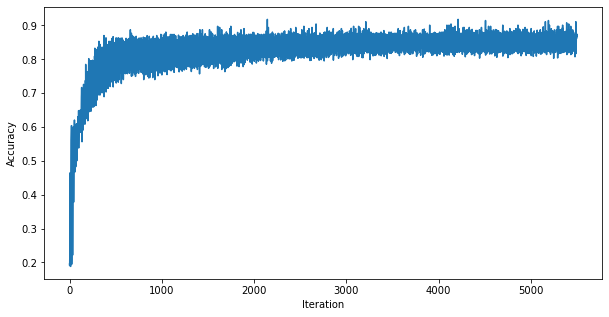

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

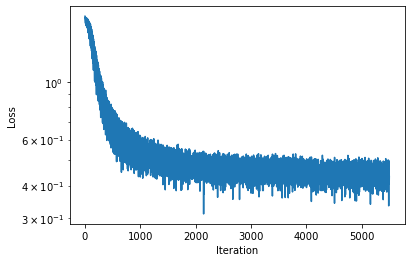

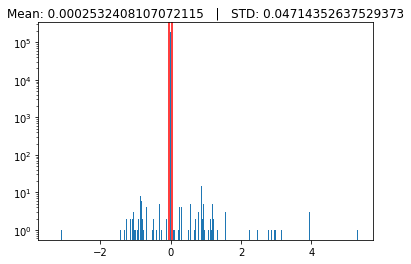

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 8.586538461538462


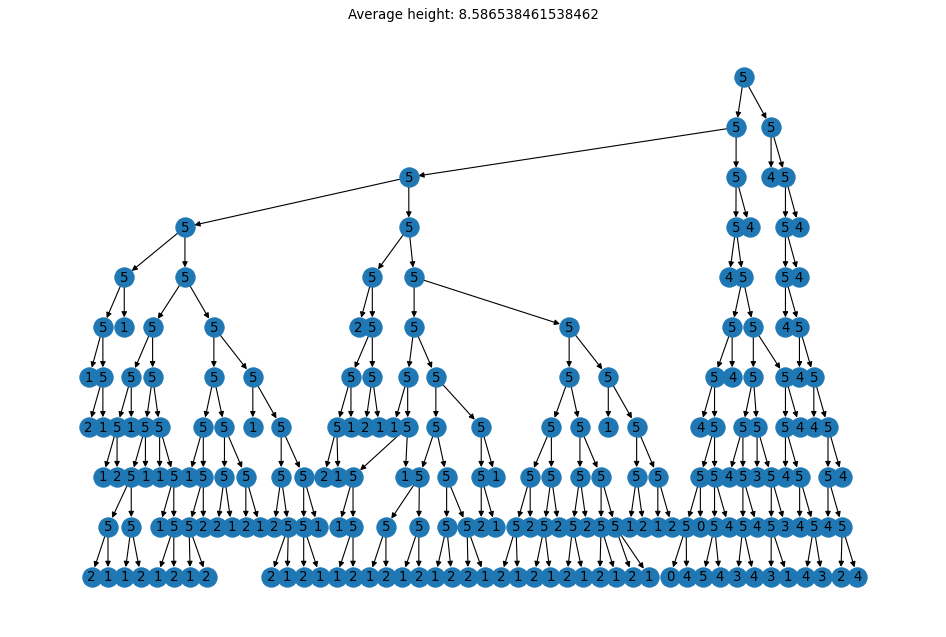

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 104


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [23]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

Accuracy: 0.8236830234527588


In [24]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

Sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1.0: 0.9723756906077348
layer 2.0: 0.9723756906077348
layer 3.0: 0.9723756906077348
layer 4.0: 0.9723756906077348
layer 5.0: 0.9723756906077348
layer 6.0: 0.9723756906077349
layer 7.0: 0.9723756906077345
layer 8.0: 0.9723756906077345


## Prune the weights

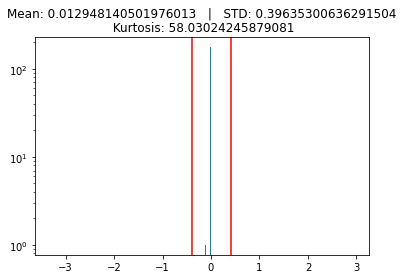

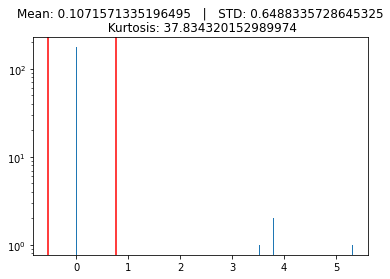

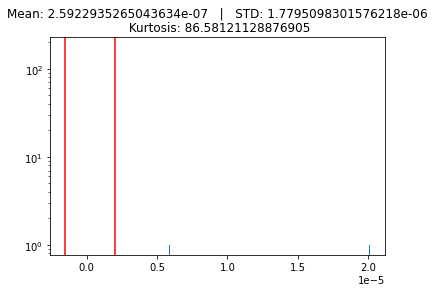

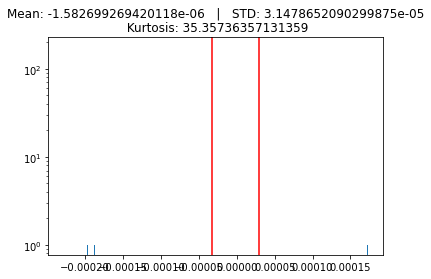

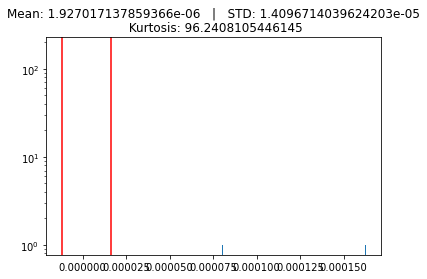

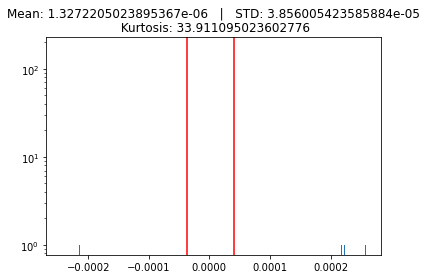

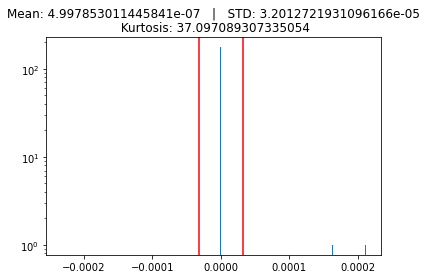

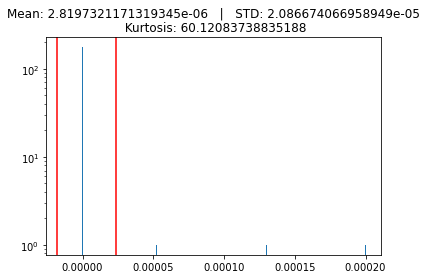

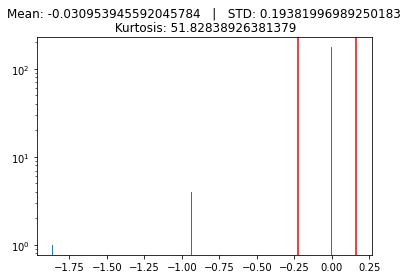

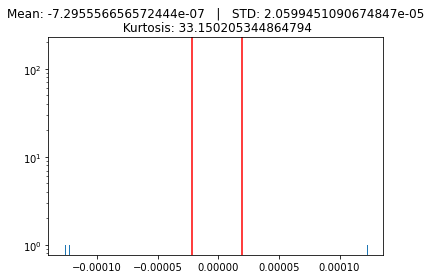

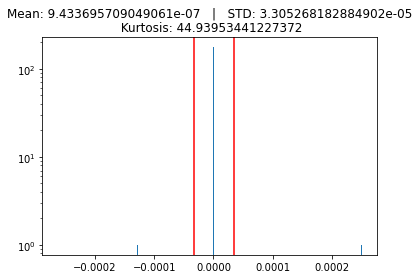

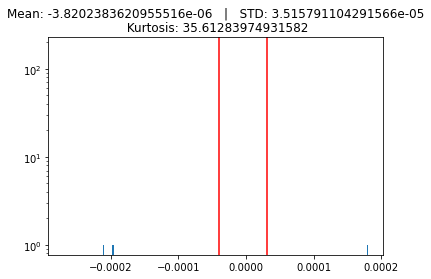

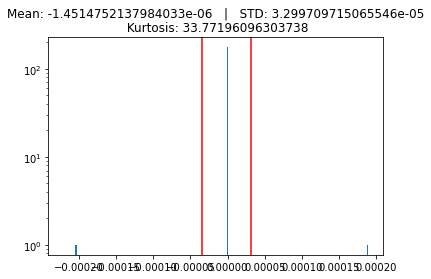

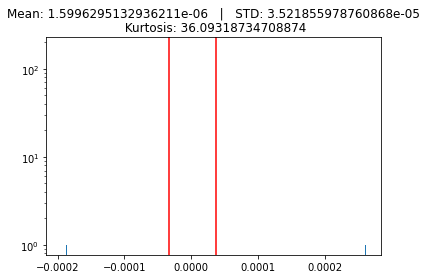

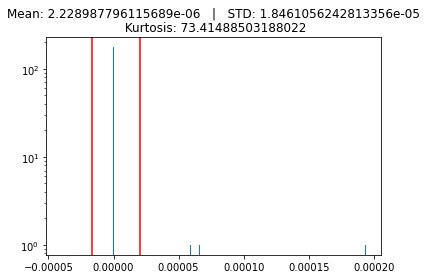

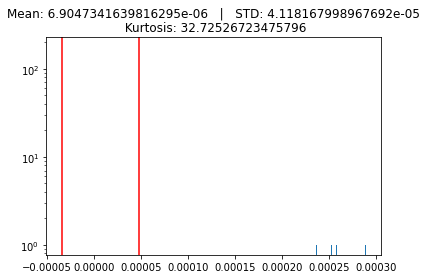

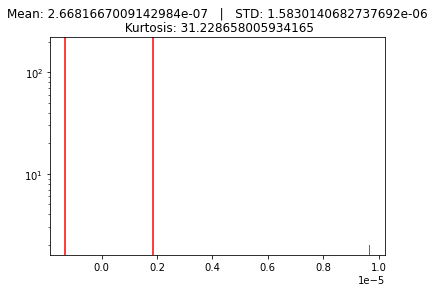

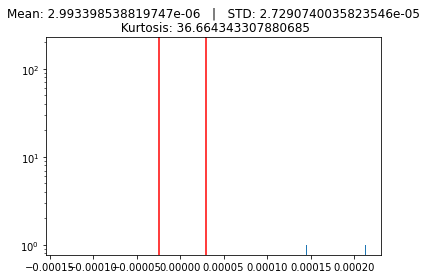

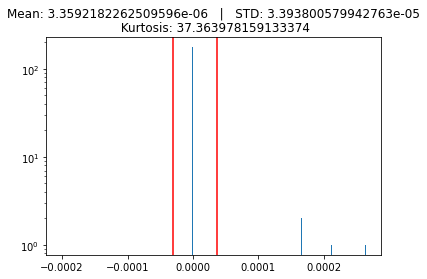

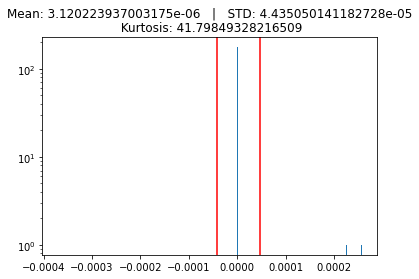

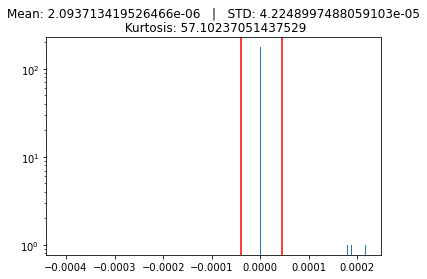

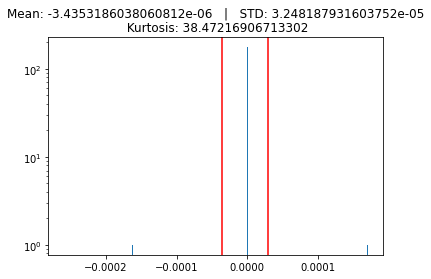

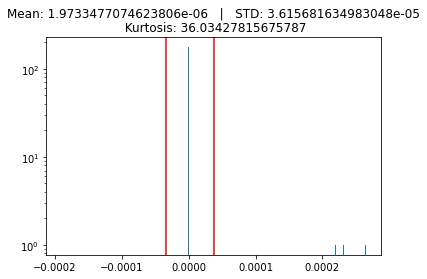

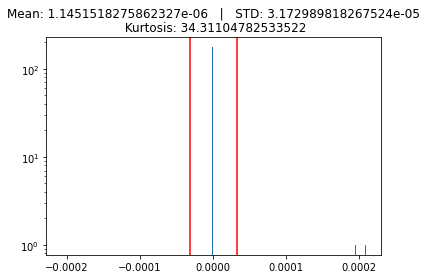

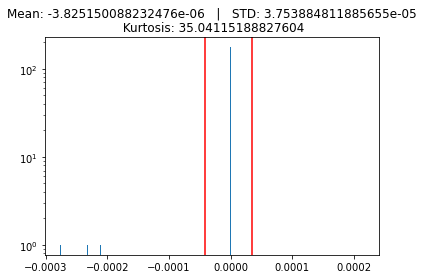

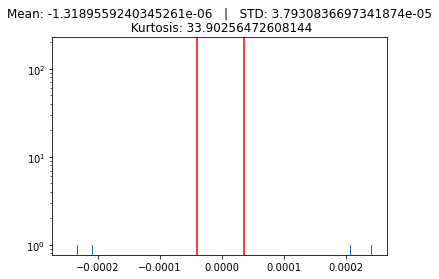

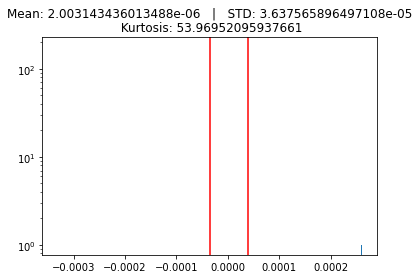

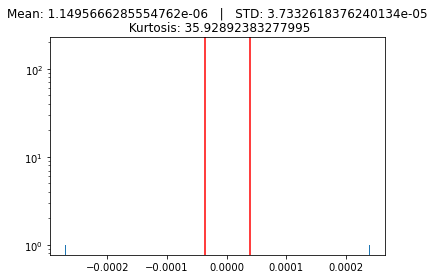

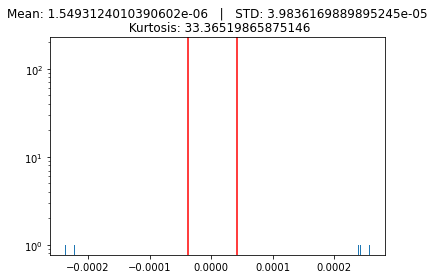

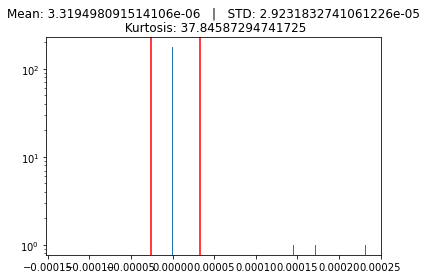

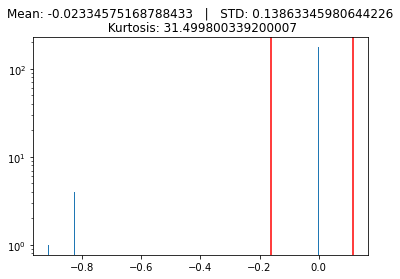

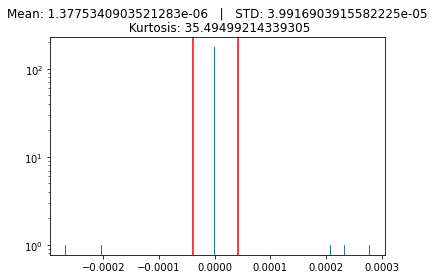

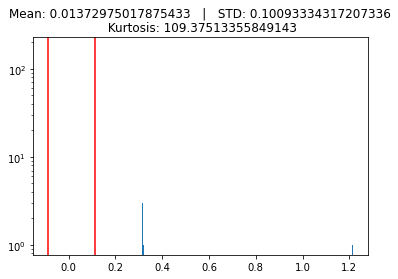

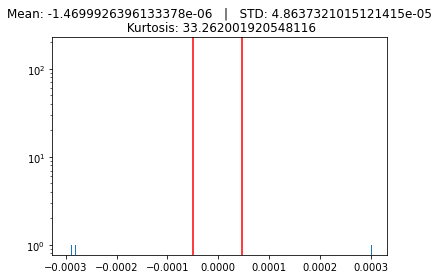

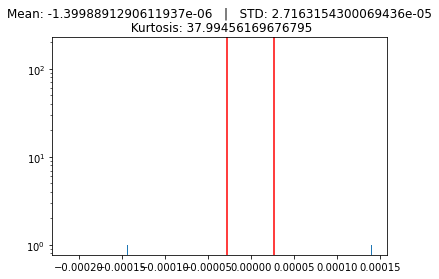

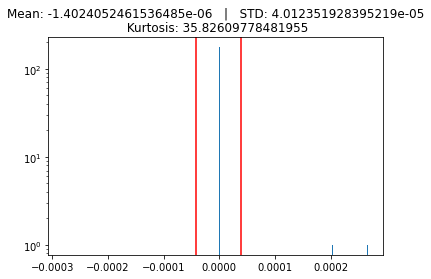

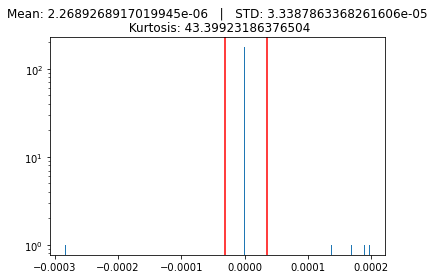

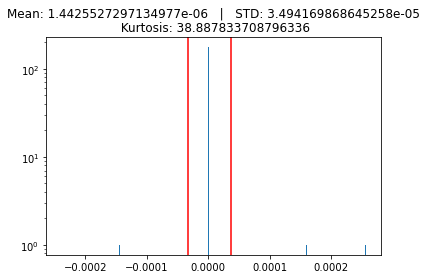

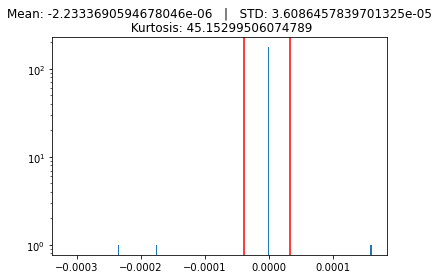

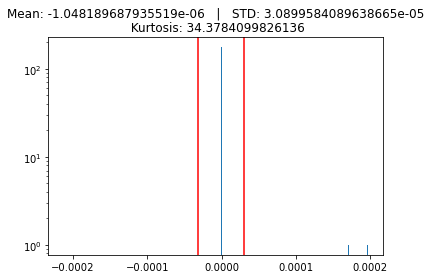

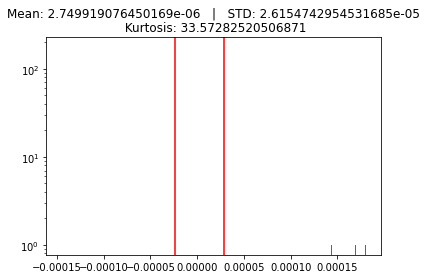

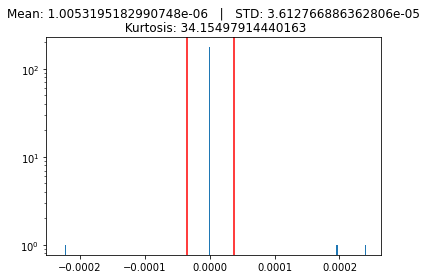

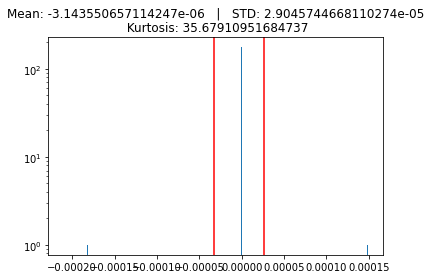

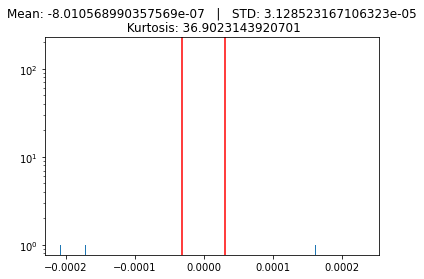

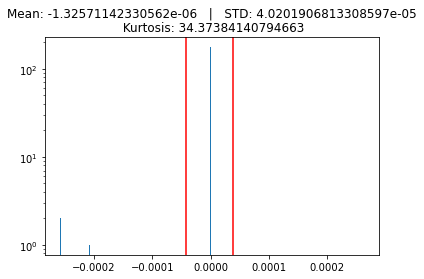

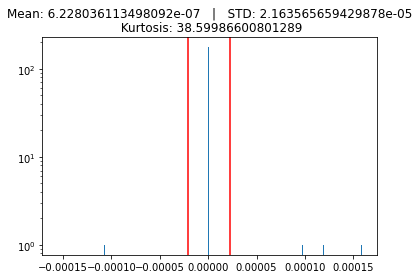

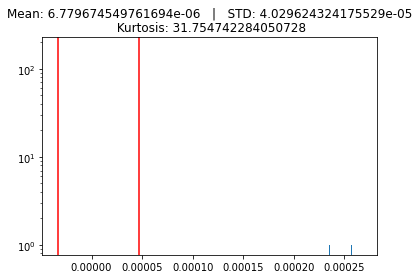

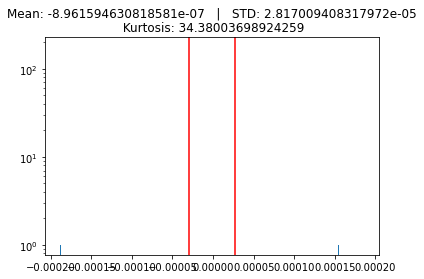

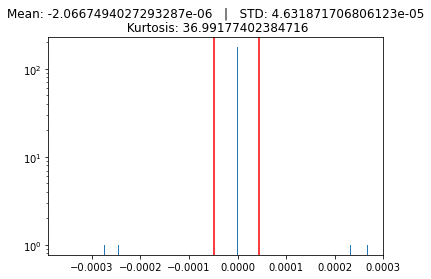

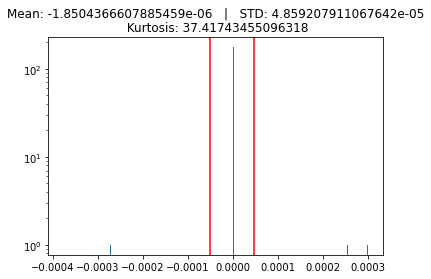

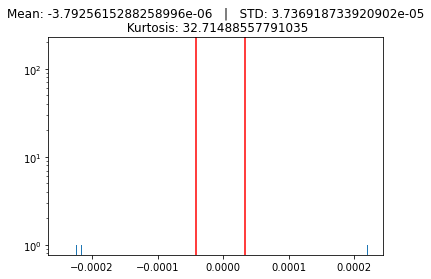

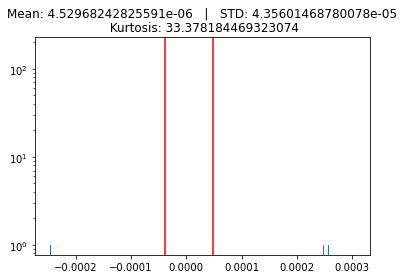

In [25]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [26]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


NameError: name 'tree_copy' is not defined

In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()